# Investigate the different values of CKA

In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy
import sklearn
import torch
import matplotlib.pyplot as plt
#from shallow_fbcsp import ShallowFBCSPNet
from collections import OrderedDict, Counter

In [3]:
df_shallow = pd.read_csv("CKA_Shallow.csv", delimiter = "\t")
df_collapsed_shallow = pd.read_csv("CKA_Collapsed_Shallow.csv", delimiter = "\t")
df_conformer = pd.read_csv("CKA_Conformer.csv", delimiter = "\t")
df_Collapsed_conformer = pd.read_csv("CKA_Collapsed_Conformer.csv", delimiter = "\t")
df_shallowRNN150 = pd.read_csv("CKA_ShallowRNN150.csv", delimiter = "\t")
df_shallowRNN200 = pd.read_csv("CKA_ShallowRNN.csv", delimiter = "\t")
df_shallowRNN250 = pd.read_csv("CKA_ShallowRNN250.csv", delimiter = "\t")
df_shallowLSTM = pd.read_csv("CKA_ShallowLSTM.csv", delimiter = "\t")
df_shallowLazyConv200 = pd.read_csv("CKA_ShallowLazyConv200.csv", delimiter = "\t")

In [4]:
set(list(df_conformer["Layer1"].values))

{'batch_norm', 'dropout', 'fc', 'pool', 'projection', 'spatial', 'temporal'}

In [5]:
df_shallow

Layer1      Layer2  CKA_Value
0     temporal    temporal   0.998992
1     temporal     spatial   0.529412
2     temporal        pool   0.025579
3     temporal     dropout   0.025579
4     temporal  batch_norm   0.407601
...        ...         ...        ...
1615        fc     spatial   0.019137
1616        fc        pool   0.626268
1617        fc     dropout   0.626268
1618        fc  batch_norm   0.243186
1619        fc          fc   0.959785

[1620 rows x 3 columns]

In [6]:
Shallow_order = ["temporal", "spatial", "batch_norm","pool", "dropout", "fc"]
Collapsed_Shallow_order = ["spatio_temporal", "batch_norm", "pool", "dropout", "fc"]
Conformer_order =  ["temporal", "spatial", "batch_norm", "pool", "dropout", "projection", "fc"]
Collapsed_Conformer_order =  ["spatio_temporal", "batch_norm", "pool", "dropout","projection", "fc"]  
ShallowRNN_order = ["RNN", "spatial", "batch_norm","pool", "dropout", "fc"]
ShallowRNN150_order = ["RNN", "spatial", "batch_norm","pool", "dropout", "fc"]
ShallowRNN250_order = ["RNN", "spatial", "batch_norm","pool", "dropout", "fc"]
ShallowLSTM_order = ["lstm", "spatial", "batch_norm","pool", "dropout", "fc"]
Shallow_LazyConv_order = ["temporal", "spatial", "batch_norm","pool", "dropout", "fc"]
    

In [7]:
import pandas as pd

# Function to get the right order of layers with CKA values, processing in batches
def get_right_order(df_model, order_list):
    # Create combinations of layers
    combination_layers = []
    for i in order_list:
        for j in order_list:
            combination_layers.append([i, j])

    # Create an empty list to store rows of new DataFrame
    new_rows = []

    # Initialize indices
    idx_1 = 0
    idx_2 = len(order_list) * len(order_list)

    # Loop over models (10 models in total)
    for model_nr in range(0, 10):  # Assuming 10 models
        # Loop through each combination of layers
        for combination in combination_layers:
            layer_1 = combination[0]
            layer_2 = combination[1]

            # Filter df_model for the current combination of Layer1 and Layer2
            df_idx_model = df_model.iloc[idx_1:idx_2]

            # Get the matching row for the current combination of layers
            matching_row = df_idx_model[(df_idx_model['Layer1'] == layer_1) & (df_idx_model['Layer2'] == layer_2)]

            # If a match is found, append it to the new rows list
            if not matching_row.empty:
                cka_value = matching_row['CKA_Value'].values[0]
                # Append the combination, its CKA value, and model_nr (if needed for later identification)
                new_rows.append([model_nr, layer_1, layer_2, cka_value])

        # Update idx_1 and idx_2 for the next iteration
        idx_1 += len(order_list) * len(order_list)
        idx_2 += len(order_list) * len(order_list)

    # Create a new dataframe from the new rows
    ordered_df_ex = pd.DataFrame(new_rows, columns=["Model", "Layer1", "Layer2", "CKA_Value"])

    # Return the ordered DataFrame
    return ordered_df_ex

    # Return the ordered DataFrame
    return ordered_df_ex


# Example usage:
# Call the function for each dataframe with its specific order list
df_ordered_shallow = get_right_order(df_shallow, Shallow_order)
df_ordered_collapsed_shallow = get_right_order(df_collapsed_shallow, Collapsed_Shallow_order)
df_ordered_conformer = get_right_order(df_conformer, Conformer_order)
df_ordered_collapsed_conformer = get_right_order(df_Collapsed_conformer, Collapsed_Conformer_order)
df_ordered_shallowRNN200 = get_right_order(df_shallowRNN200, ShallowRNN_order)
df_ordered_shallowRNN150 = get_right_order(df_shallowRNN150, ShallowRNN150_order)
df_ordered_shallowRNN250 = get_right_order(df_shallowRNN250, ShallowRNN250_order)
df_ordered_shallowLSTM = get_right_order(df_shallowLSTM, ShallowLSTM_order)
df_ordered_shallowLazyConv200 = get_right_order(df_shallowLazyConv200, Shallow_LazyConv_order)
# Display the ordered DataFrame (for testing purposes)
print(df_ordered_shallow)


     Model    Layer1      Layer2  CKA_Value
0        0  temporal    temporal   0.998992
1        0  temporal     spatial   0.529412
2        0  temporal  batch_norm   0.407601
3        0  temporal        pool   0.025579
4        0  temporal     dropout   0.025579
..     ...       ...         ...        ...
355      9        fc     spatial   0.018843
356      9        fc  batch_norm   0.240819
357      9        fc        pool   0.625869
358      9        fc     dropout   0.625869
359      9        fc          fc   0.940419

[360 rows x 4 columns]


In [8]:
from collections import defaultdict

# Create a defaultdict with float so missing keys start at 0.0
def mean_and_count(df):
    cka_counter = defaultdict(list)

    # Iterate over DataFrame and add CKA values to the counter
    for _, row in df.iterrows():
        pair = (row['Layer1'], row['Layer2'])
        cka_counter[pair].append(row['CKA_Value'])

    # Check what we’ve got

    mean_dict = {}
    for pair, total_cka in cka_counter.items():
        avg_cka = sum(total_cka)/len(total_cka)
        mean_dict[pair] = avg_cka
        #print(f"{pair}: {total_cka}")
    return cka_counter, mean_dict

shallow_counter_dict, shallow_mean_dict = mean_and_count(df_ordered_shallow)
collapsed_shallow_counter_dict, collapsed_shallow_mean_dict = mean_and_count(df_ordered_collapsed_shallow)
conformer_counter_dict, conformer_mean_dict = mean_and_count(df_ordered_conformer)
Collapsed_conformer_counter_dict, Collapsed_conformer_mean_dict = mean_and_count(df_ordered_collapsed_conformer)
shallowRNN200_counter_dict, shallowRNN200_mean_dict = mean_and_count(df_ordered_shallowRNN200)
shallowRNN150_counter_dict, shallowRNN150_mean_dict = mean_and_count(df_ordered_shallowRNN150)
shallowRNN250_counter_dict, shallowRNN250_mean_dict = mean_and_count(df_ordered_shallowRNN250)
shallowLSTM_counter_dict, shallowLSTM_mean_dict = mean_and_count(df_ordered_shallowLSTM)
shallowLazyConv200_counter_dict, shallowLazyConv200_mean_dict = mean_and_count(df_ordered_shallowLazyConv200)


In [9]:
#mean_dict

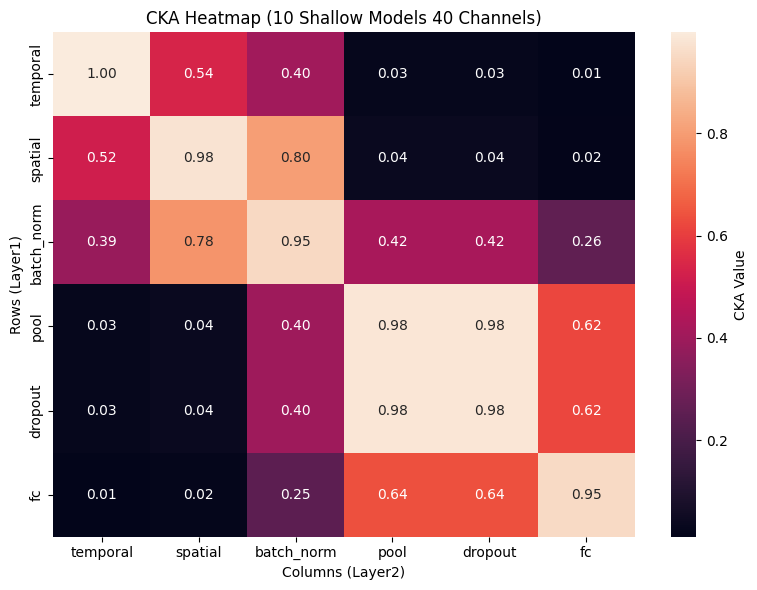

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cka_heatmap(mean_dict, title):
    # Extract unique row and column labels
    rows = [key[0] for key in mean_dict.keys()]
    rows = list(dict.fromkeys(rows))  # Remove duplicates while preserving order
    cols = [key[1] for key in mean_dict.keys()]
    cols = list(dict.fromkeys(cols))  # Remove duplicates while preserving order

    # Create an empty DataFrame filled with NaN
    heatmap_data = pd.DataFrame(index=rows, columns=cols)

    # Populate the DataFrame with the values from mean_dict
    for (row, col), value in mean_dict.items():
        heatmap_data.at[row, col] = value

    # Convert to float (since NaN handling can create object types)
    heatmap_data = heatmap_data.astype(float)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cbar_kws={'label': 'CKA Value'})
    
    # Optional: customize axes labels and title
    plt.title(title)
    plt.xlabel('Columns (Layer2)')
    plt.ylabel('Rows (Layer1)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `mean_dict` is already defined as your dictionary of CKA values
plot_cka_heatmap(shallow_mean_dict, 'CKA Heatmap (10 Shallow Models 40 Channels)')


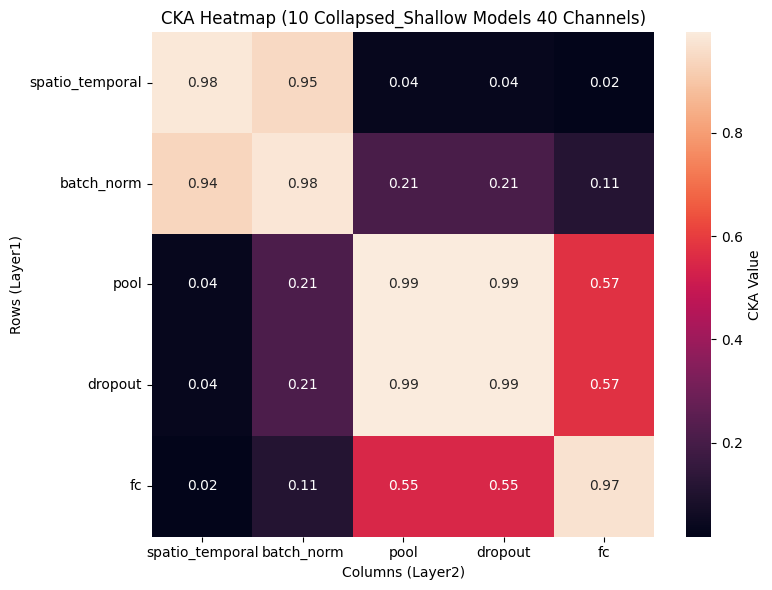

In [11]:
plot_cka_heatmap(collapsed_shallow_mean_dict, 'CKA Heatmap (10 Collapsed_Shallow Models 40 Channels)')

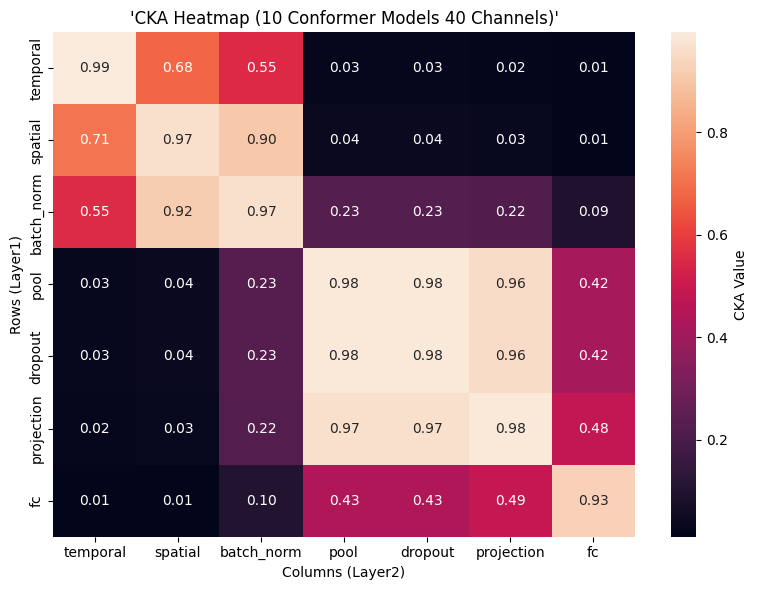

In [12]:
plot_cka_heatmap(conformer_mean_dict, "'CKA Heatmap (10 Conformer Models 40 Channels)'")

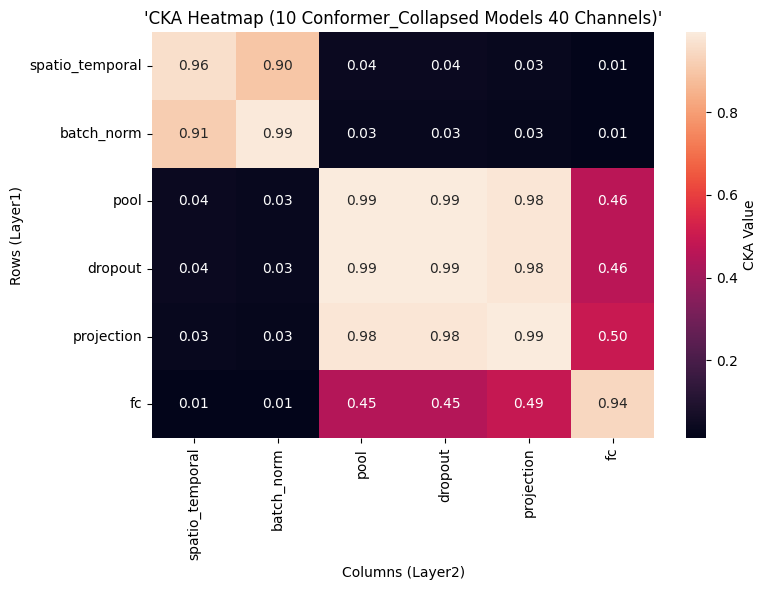

In [13]:
plot_cka_heatmap(Collapsed_conformer_mean_dict, "'CKA Heatmap (10 Conformer_Collapsed Models 40 Channels)'")

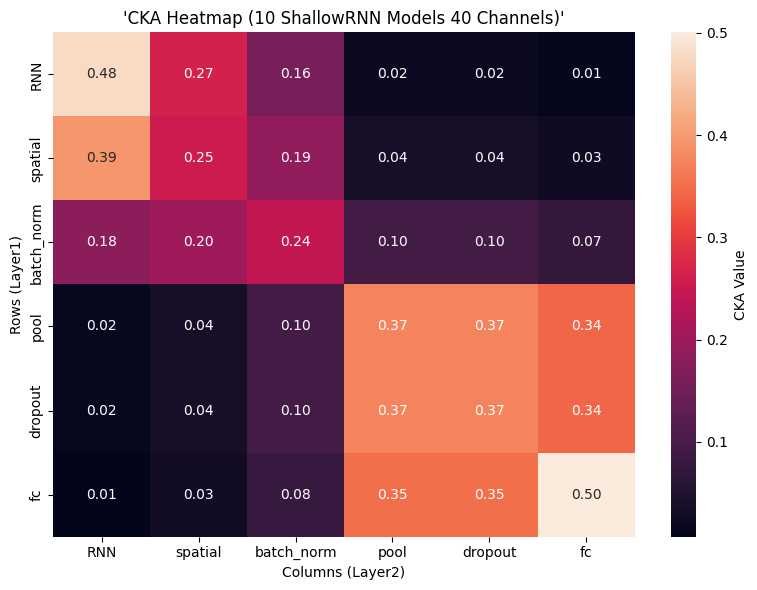

In [14]:
plot_cka_heatmap(shallowRNN150_mean_dict, "'CKA Heatmap (10 ShallowRNN Models 40 Channels)'")

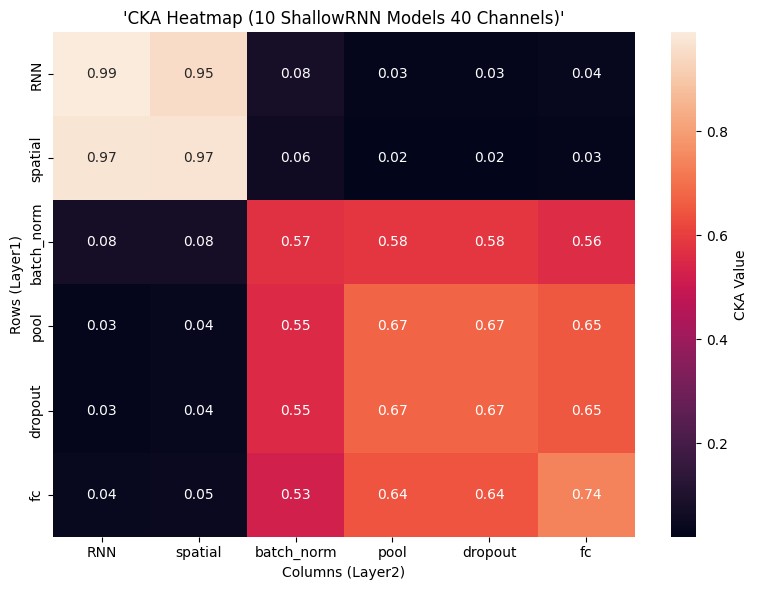

In [15]:
plot_cka_heatmap(shallowRNN200_mean_dict, "'CKA Heatmap (10 ShallowRNN Models 40 Channels)'")

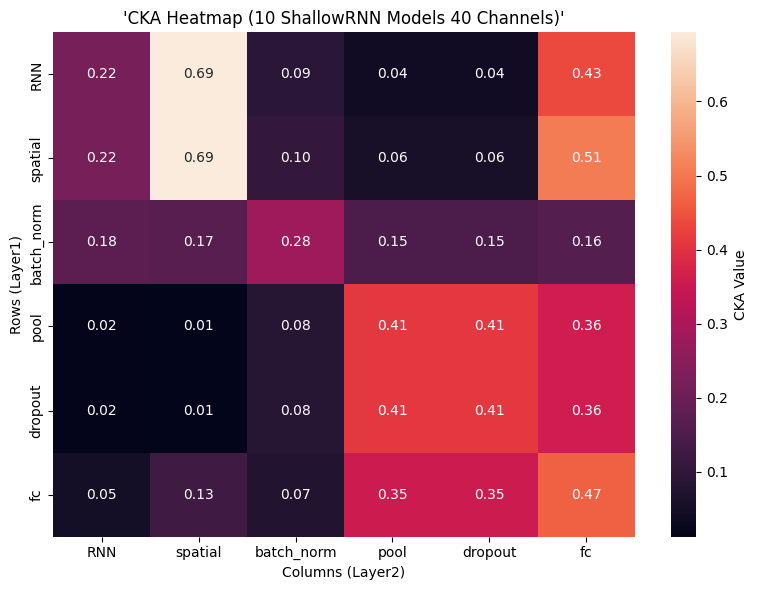

In [16]:
plot_cka_heatmap(shallowRNN250_mean_dict, "'CKA Heatmap (10 ShallowRNN Models 40 Channels)'")

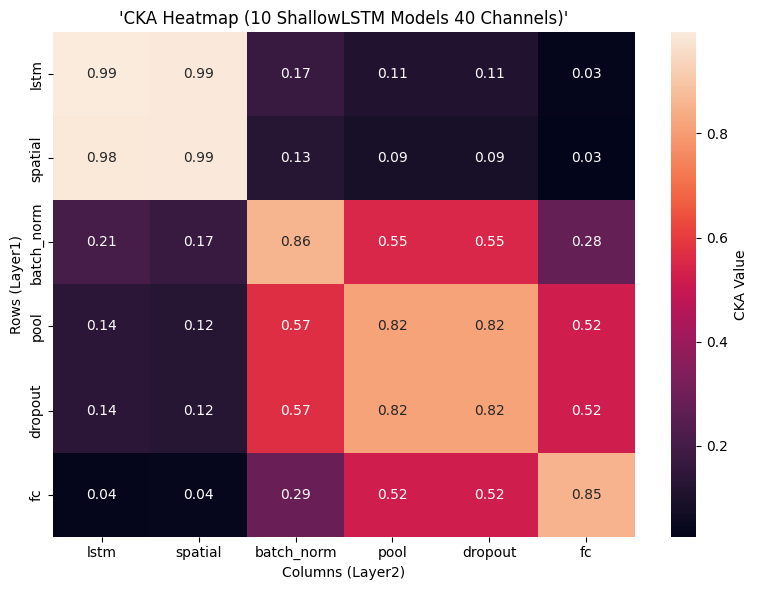

In [17]:
plot_cka_heatmap(shallowLSTM_mean_dict, "'CKA Heatmap (10 ShallowLSTM Models 40 Channels)'")

In [18]:
#plot_cka_heatmap(shallowLazyConv200_mean_dict, "'CKA Heatmap (10 ShallowLazyConv Models 40 Channels)'")

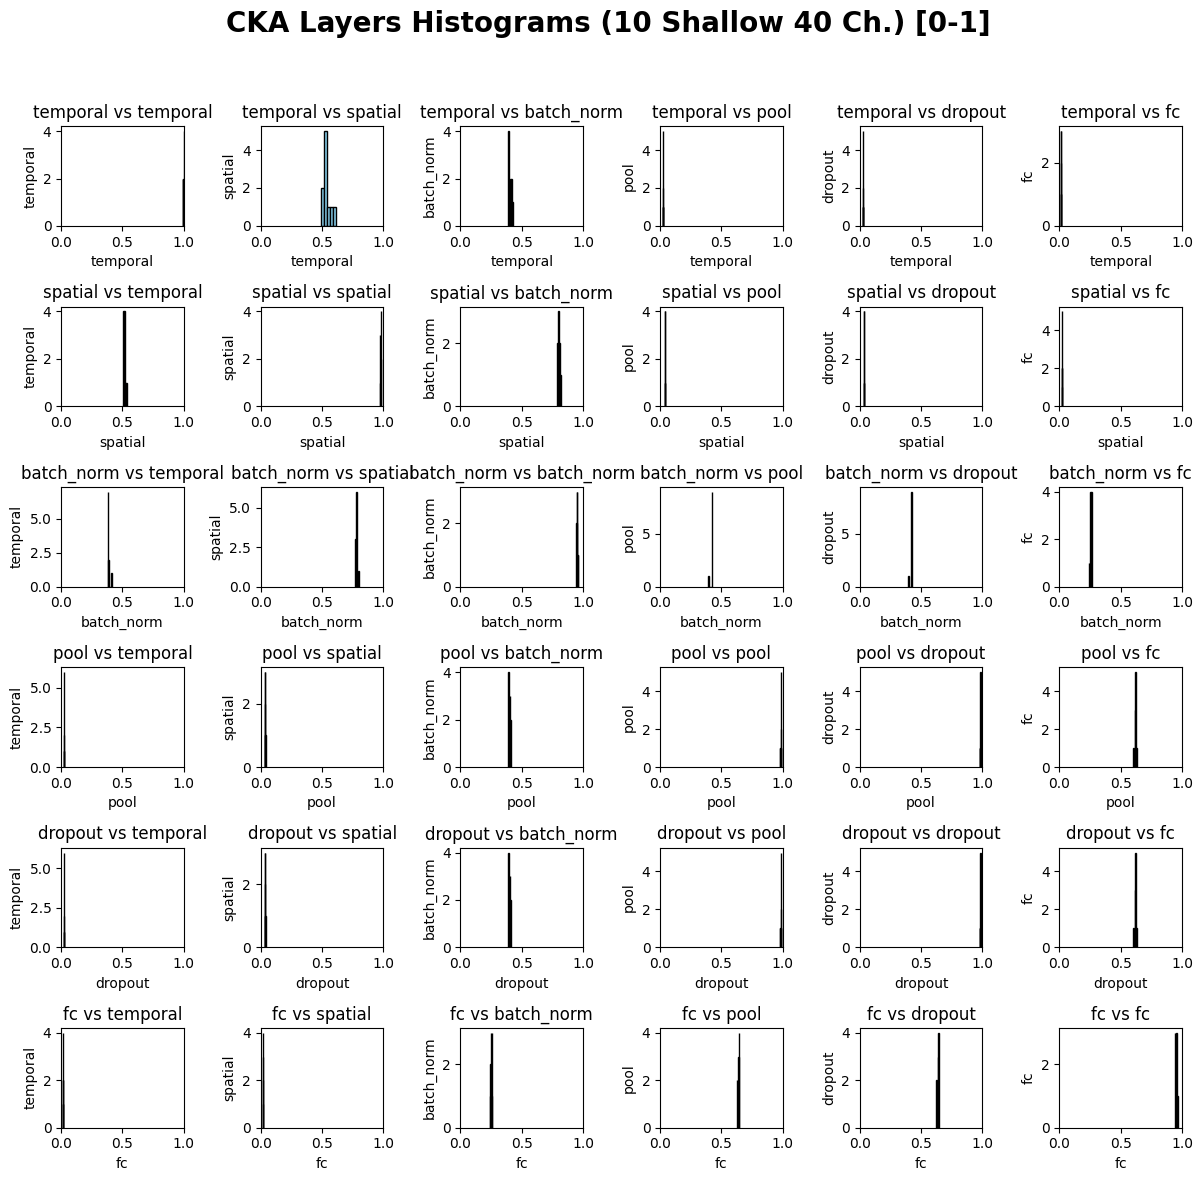

In [19]:

def plot_cka_histograms(counter_dict, title):
    # Set up a 3x3 grid of subplots
    rows_cols = int(len(list(counter_dict.keys()))**0.5)
    fig, axes = plt.subplots(rows_cols, rows_cols, figsize=(12, 12))

    # Flatten axes array so we can iterate over it
    axes = axes.flatten()

    # Iterate over the defaultdict and plot each pair's histogram
    for idx, ((layer1, layer2), values) in enumerate(counter_dict.items()):
        ax = axes[idx]
        ax.set_xlim(0, 1)  # Set X-axis limits from 0 to 1
        # Plot histogram
        ax.hist(values, bins=5, color='skyblue', edgecolor='black')
        # Set titles and labels
        ax.set_title(f"{layer1} vs {layer2}")
        ax.set_xlabel(layer1)
        ax.set_ylabel(layer2)

    # Hide any unused subplots (if there are fewer than 9 pairs)
    for ax in axes[len(counter_dict):]:
        ax.set_visible(False)

    # Set overall title on the figure
    fig.suptitle(title, fontsize=20, weight='bold')

    # Adjust layout to avoid overlapping with the overall title
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()

# Example usage:
# Assuming 'shallow_counter_dict' is your dictionary with CKA values
plot_cka_histograms(shallow_counter_dict, 'CKA Layers Histograms (10 Shallow 40 Ch.) [0-1]')


In [20]:
#collapsed_shallow_counter_dict

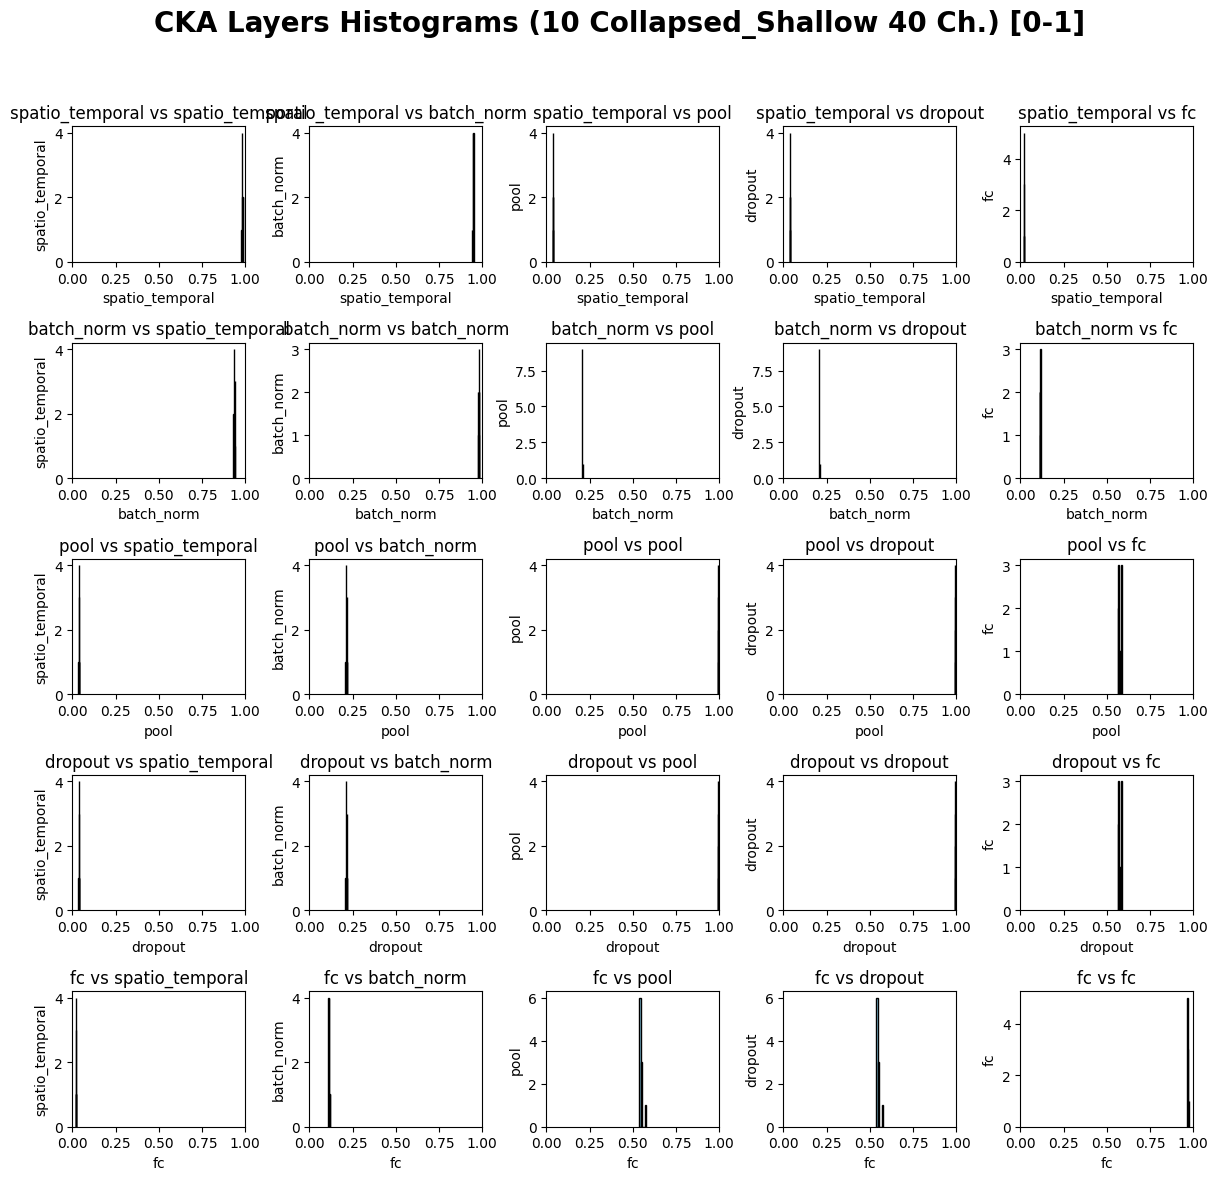

In [21]:
plot_cka_histograms(collapsed_shallow_counter_dict, 'CKA Layers Histograms (10 Collapsed_Shallow 40 Ch.) [0-1]')

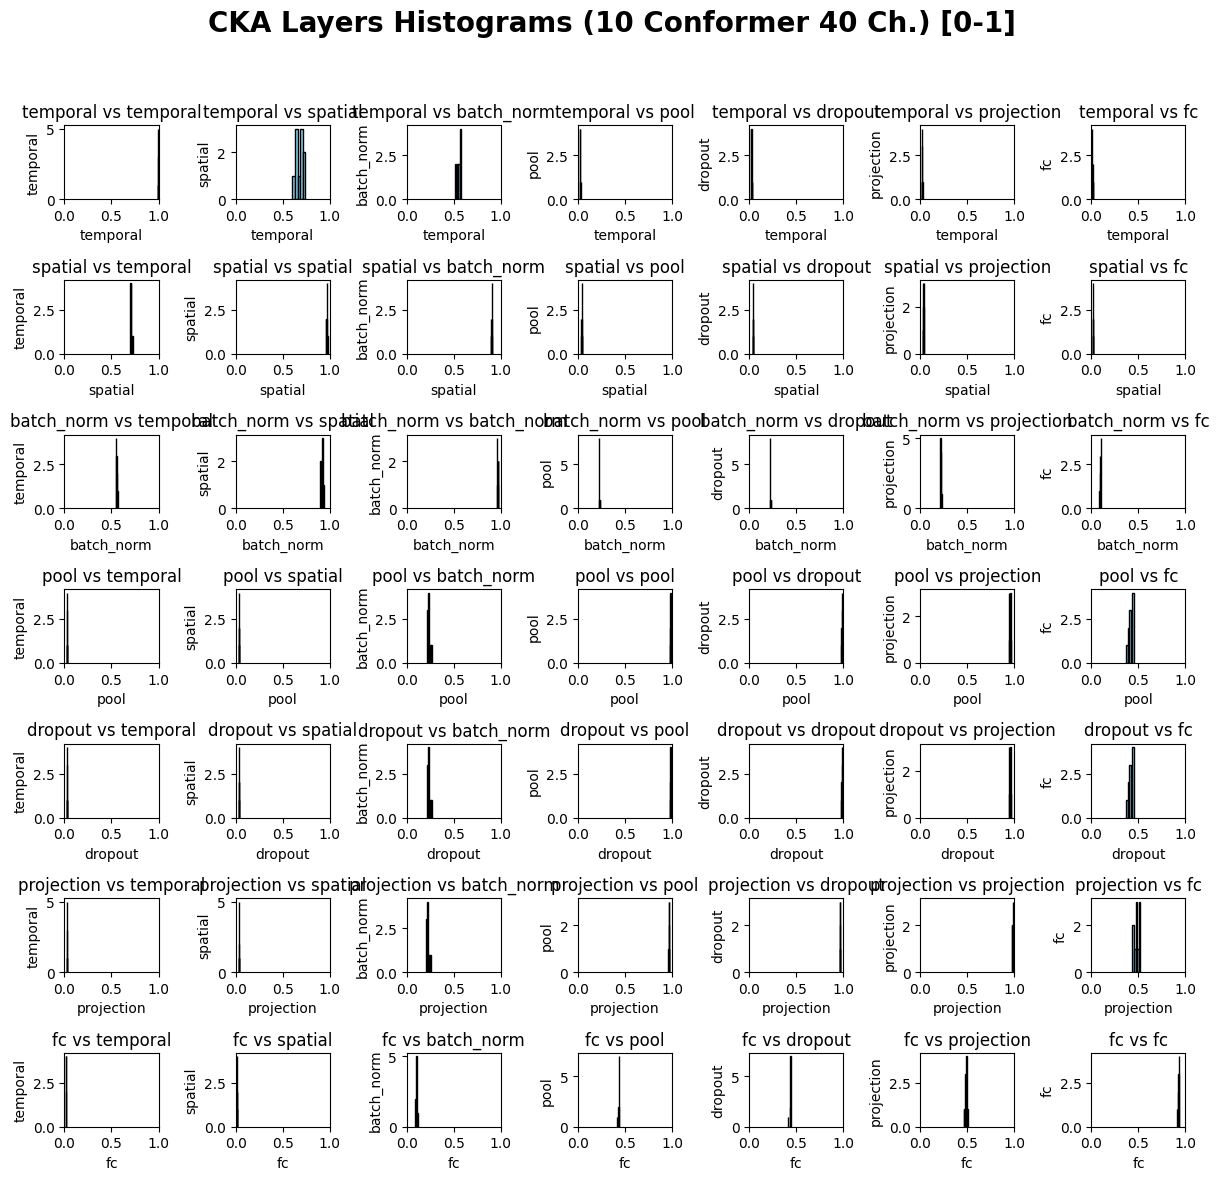

In [22]:
plot_cka_histograms(conformer_counter_dict, 'CKA Layers Histograms (10 Conformer 40 Ch.) [0-1]')

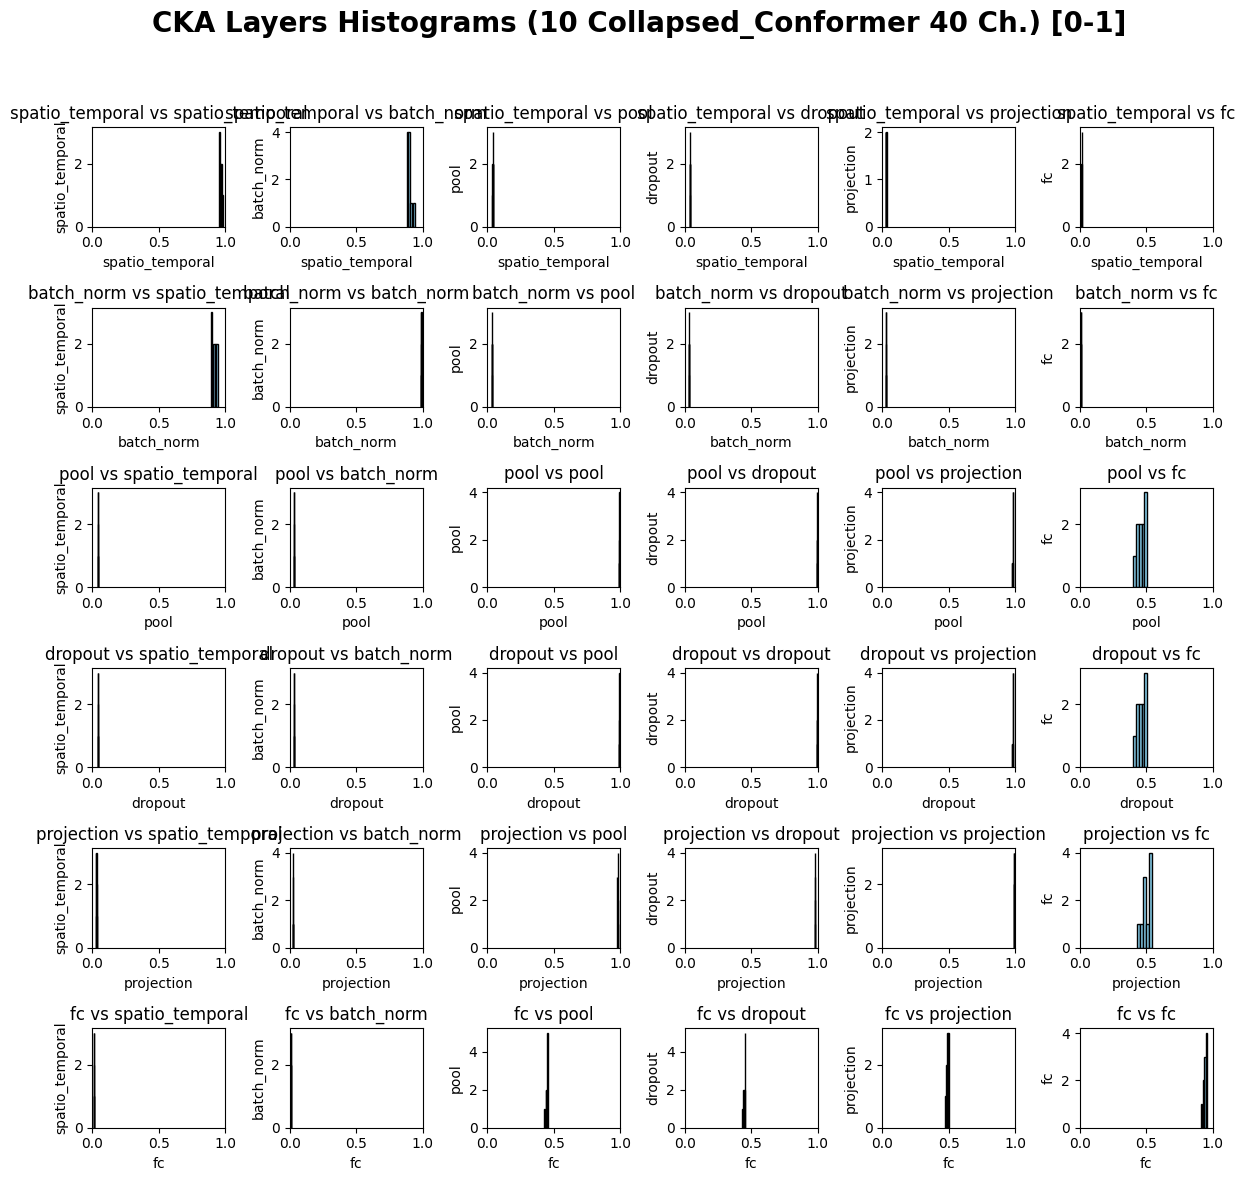

In [23]:
plot_cka_histograms(Collapsed_conformer_counter_dict, 'CKA Layers Histograms (10 Collapsed_Conformer 40 Ch.) [0-1]')

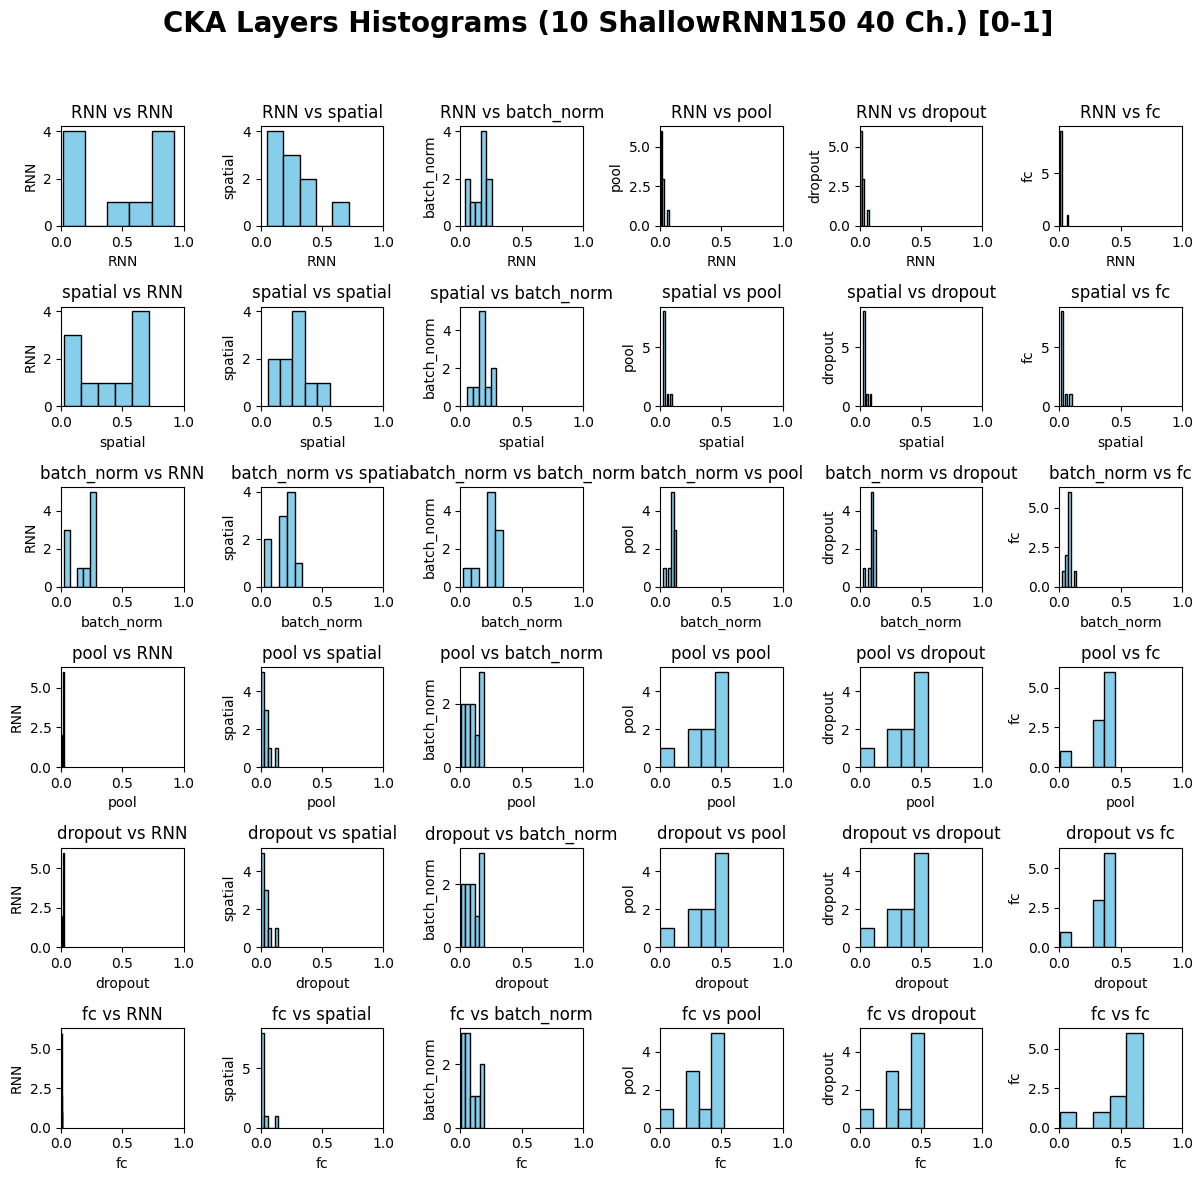

In [24]:
plot_cka_histograms(shallowRNN150_counter_dict, 'CKA Layers Histograms (10 ShallowRNN150 40 Ch.) [0-1]')

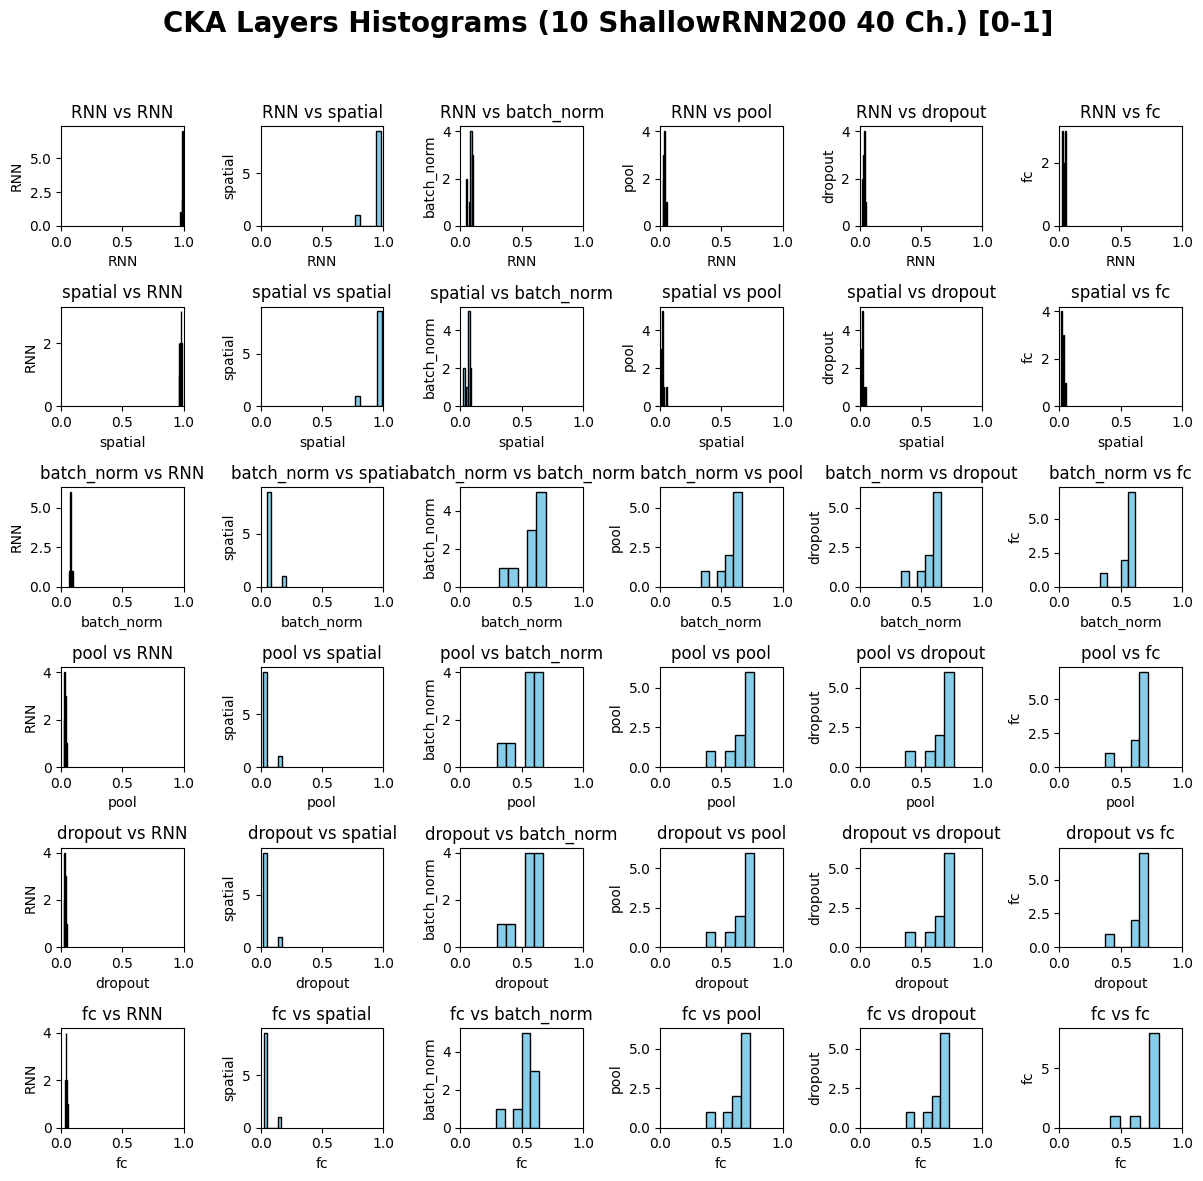

In [25]:
plot_cka_histograms(shallowRNN200_counter_dict, 'CKA Layers Histograms (10 ShallowRNN200 40 Ch.) [0-1]')

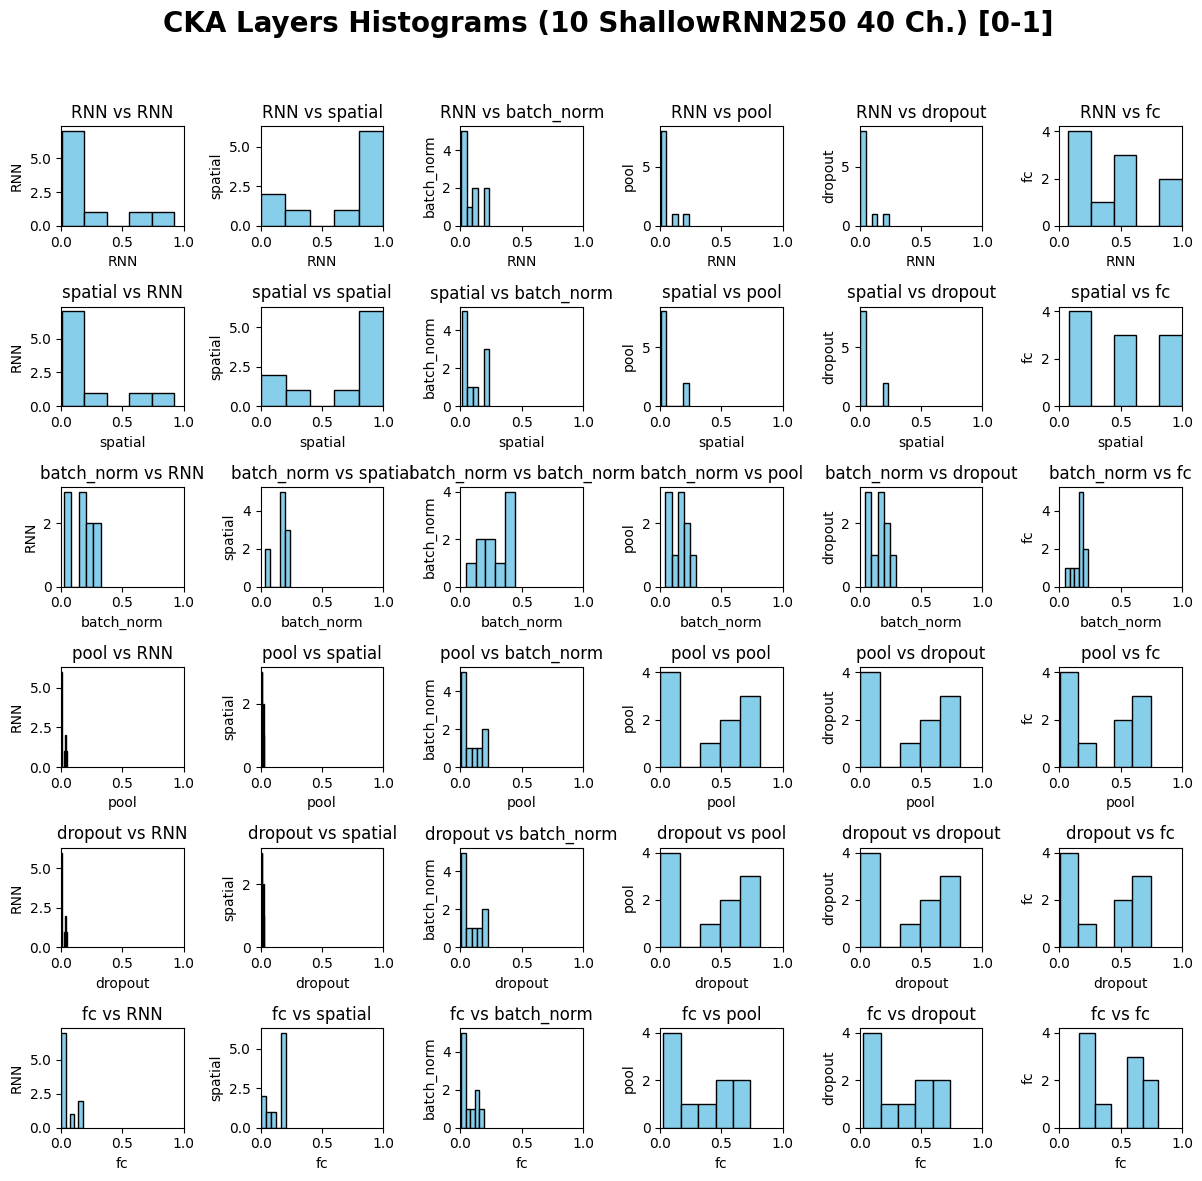

In [26]:
plot_cka_histograms(shallowRNN250_counter_dict, 'CKA Layers Histograms (10 ShallowRNN250 40 Ch.) [0-1]')

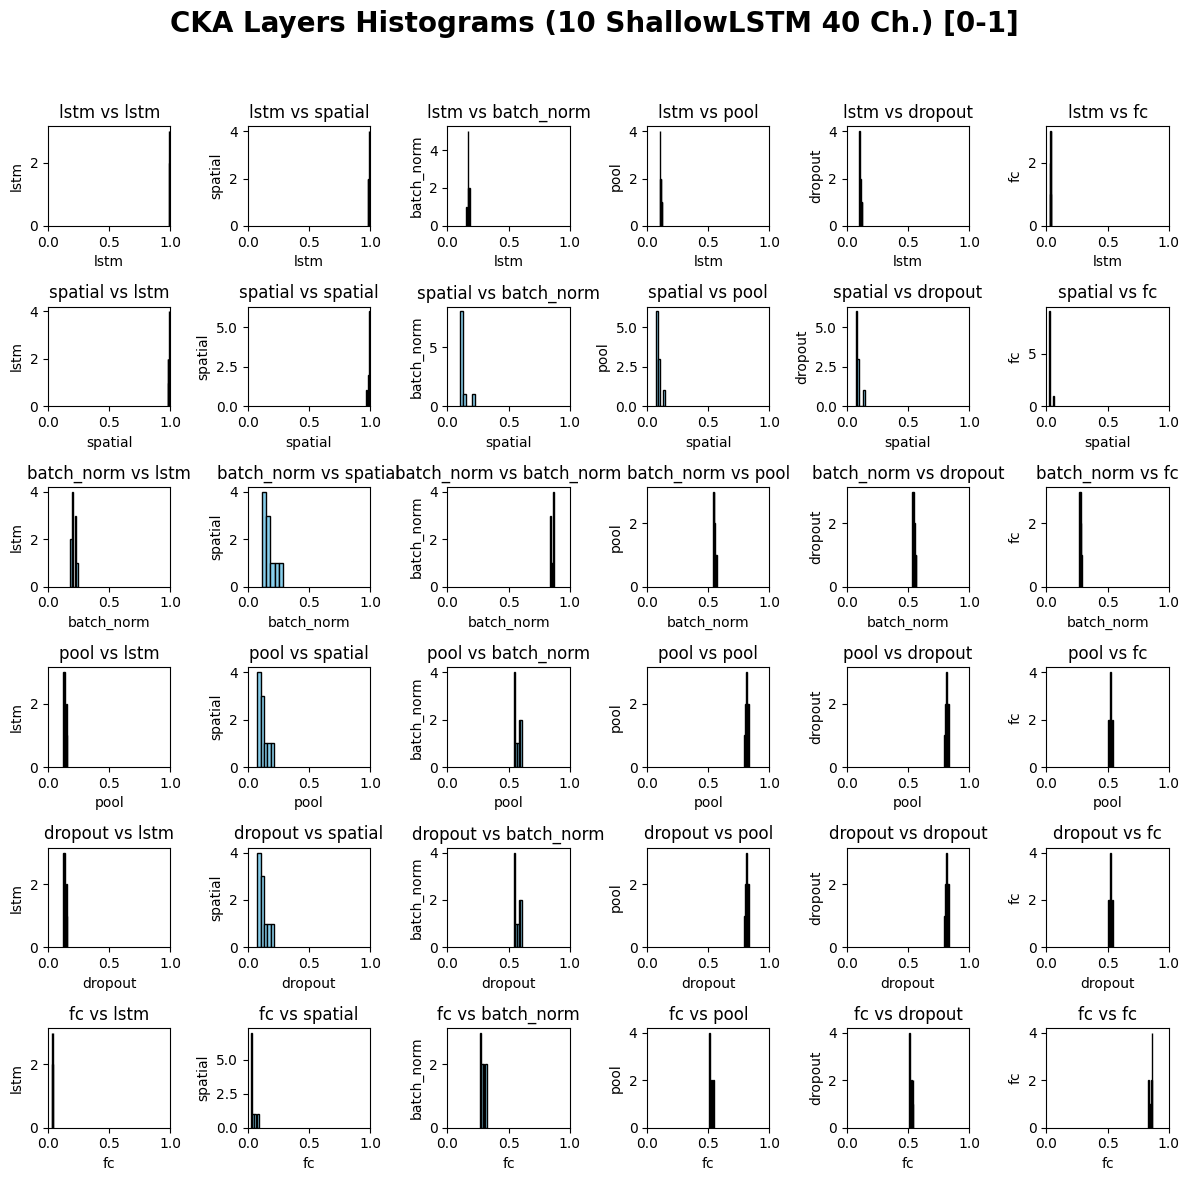

In [27]:
plot_cka_histograms(shallowLSTM_counter_dict, 'CKA Layers Histograms (10 ShallowLSTM 40 Ch.) [0-1]')

In [28]:
### Non-parametric-bootrap which enforces Between 0 and 1.
def non_parametric_bootstrap(data, stat_func, n_resamples=2000):
    resamples = np.random.choice(data, size=(n_resamples, len(data)), replace=True)
    return np.apply_along_axis(stat_func, 1, resamples)


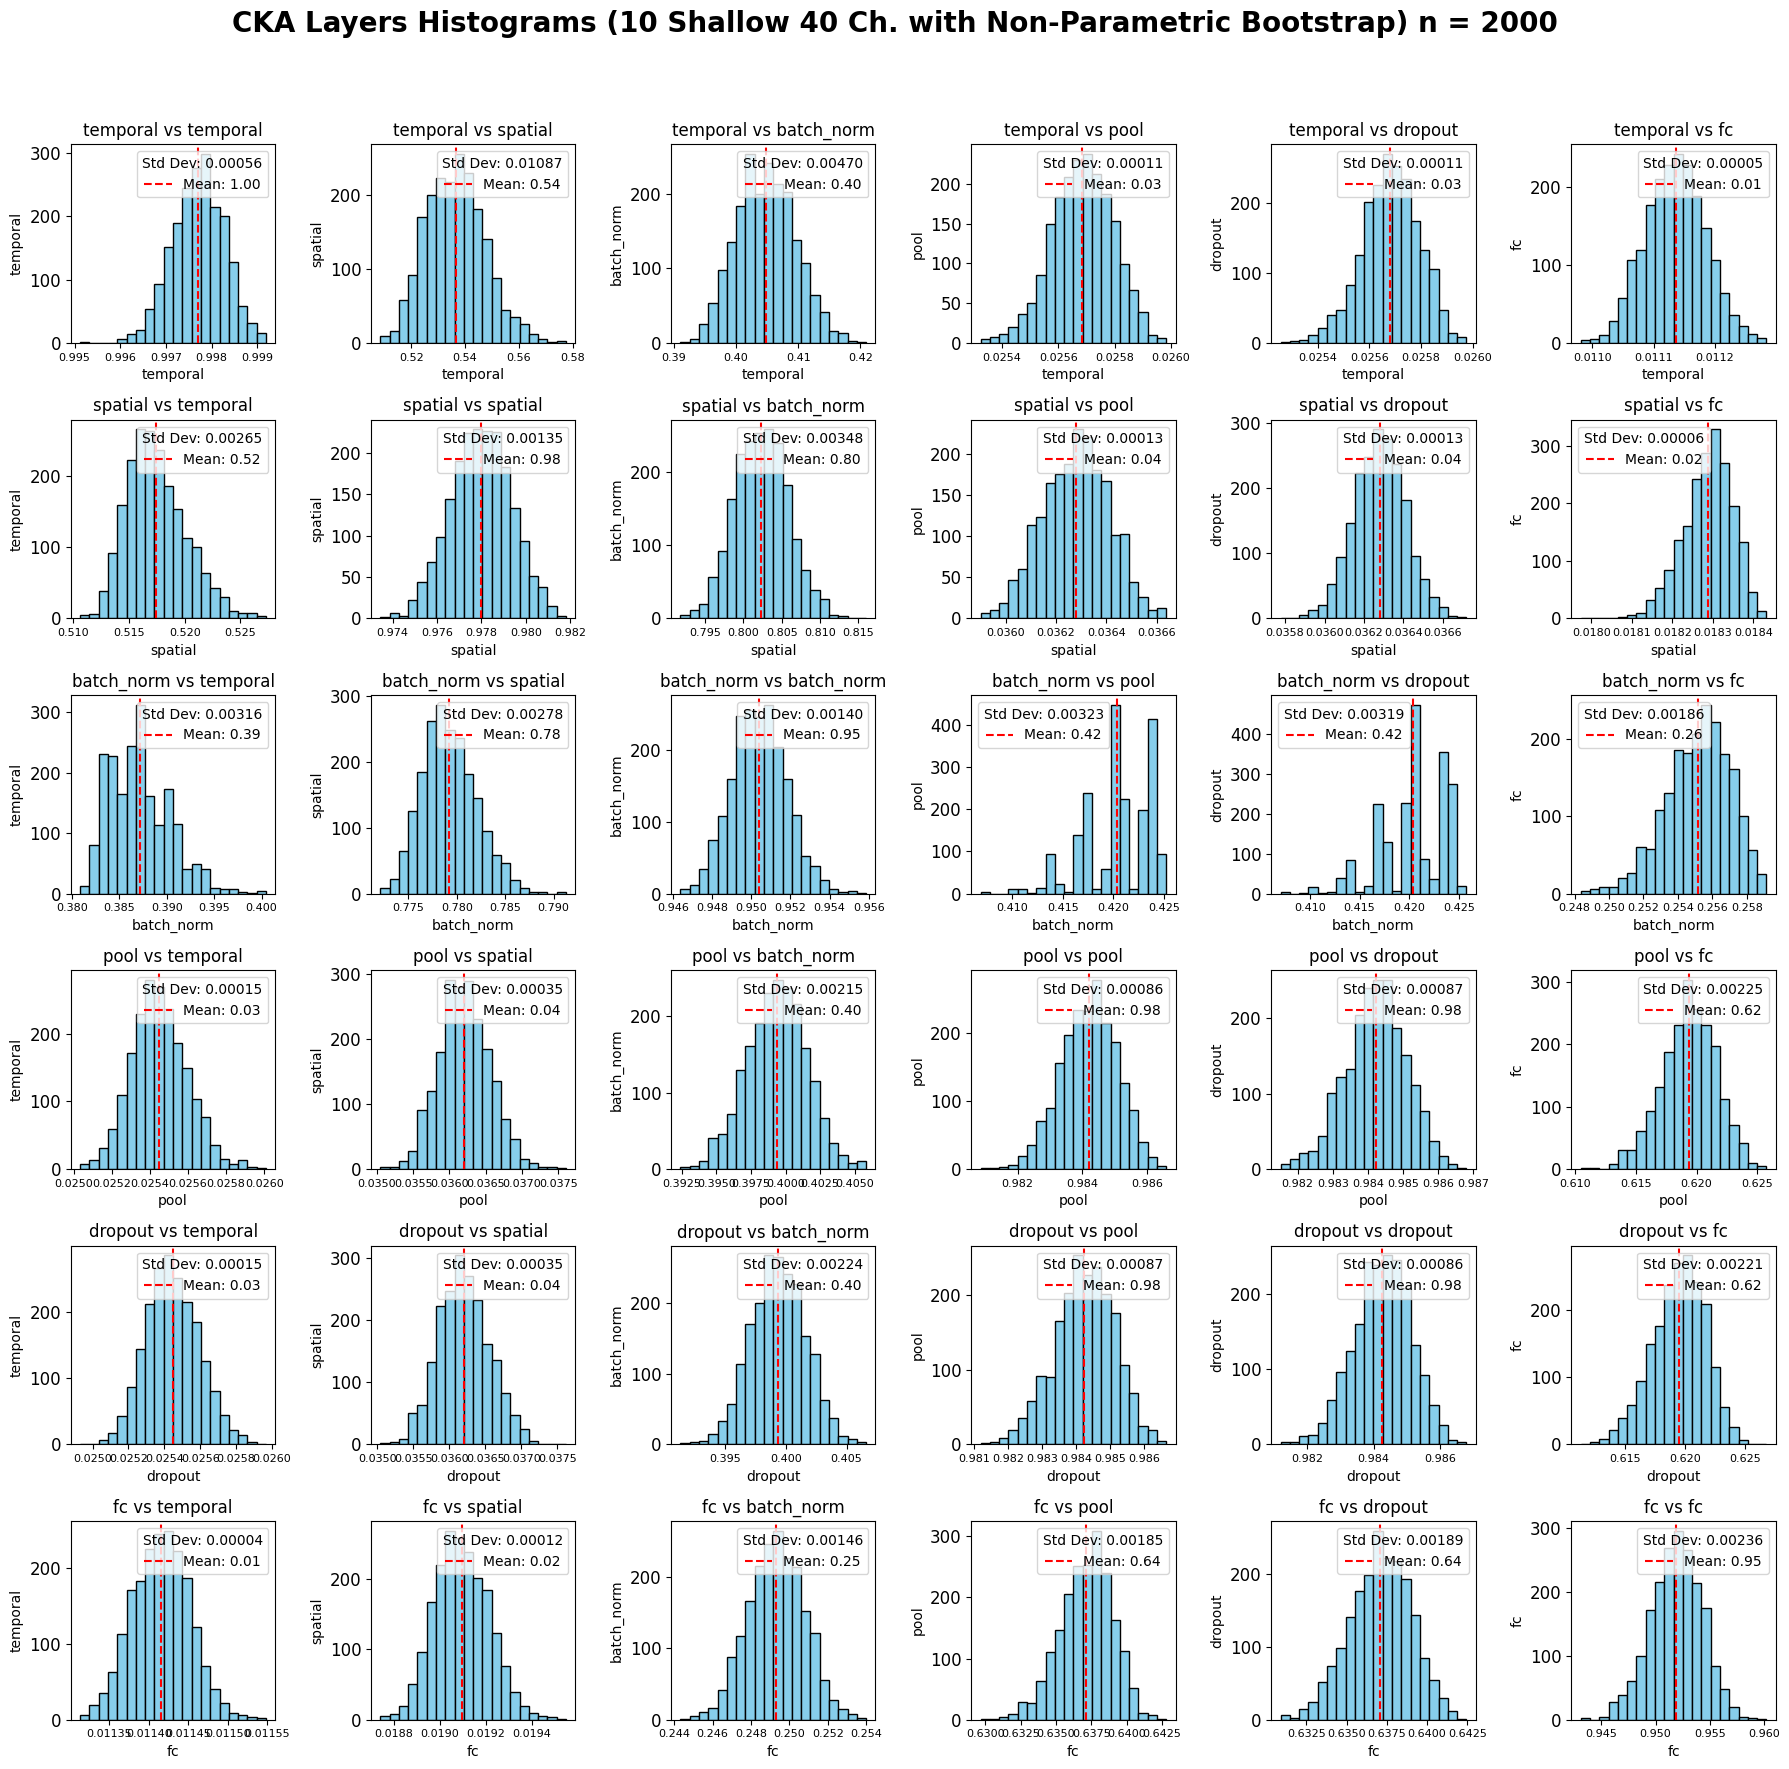

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cka_histograms_with_bootstrap(cka_counter, title):
    # Set up a grid of subplots
    rows_cols = int(len(list(cka_counter.keys()))**0.5)
    fig, axes = plt.subplots(rows_cols, rows_cols, figsize=(18, 18))

    # Flatten axes array so we can iterate over it
    axes = axes.flatten()

    # Dictionaries to store final mean and std for each layer pair
    mean_v_dict = {}
    std_v_dict = {}

    # Iterate over cka_counter and plot histograms
    for idx, ((layer1, layer2), values) in enumerate(cka_counter.items()):
        ax = axes[idx]

        # Apply non-parametric bootstrap
        meanx = non_parametric_bootstrap(np.array(values), np.mean)
        mean_v = np.mean(meanx)
        std_v = np.std(meanx)

        # Store the final mean and std dev
        mean_v_dict[(layer1, layer2)] = mean_v
        std_v_dict[(layer1, layer2)] = std_v

        # Plot histogram
        ax.hist(meanx, bins=20, color='skyblue', edgecolor='black')

        # Add vertical line for mean with label formatted to 2 decimal places
        ax.axvline(mean_v, color="red", linestyle="--", label=f"Mean: {mean_v:.2f}")

        # Add standard deviation to the legend
        ax.legend(title=f"Std Dev: {std_v:.5f}")

        # Set title and labels
        ax.set_title(f"{layer1} vs {layer2}")
        ax.set_xlabel(layer1)
        ax.set_ylabel(layer2)

        # Adjust tick label sizes
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=12)

    # Hide any unused subplots
    for ax in axes[len(cka_counter):]:
        ax.set_visible(False)

    # Overall figure title
    fig.suptitle(title, fontsize=20, weight='bold')

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()

    return mean_v_dict, std_v_dict

# Example usage:
# Assuming `cka_counter` is your dictionary with CKA values
shallow_mean_v_dict, shallow_std_v_dict = plot_cka_histograms_with_bootstrap(
    shallow_counter_dict,
    'CKA Layers Histograms (10 Shallow 40 Ch. with Non-Parametric Bootstrap) n = 2000'
)


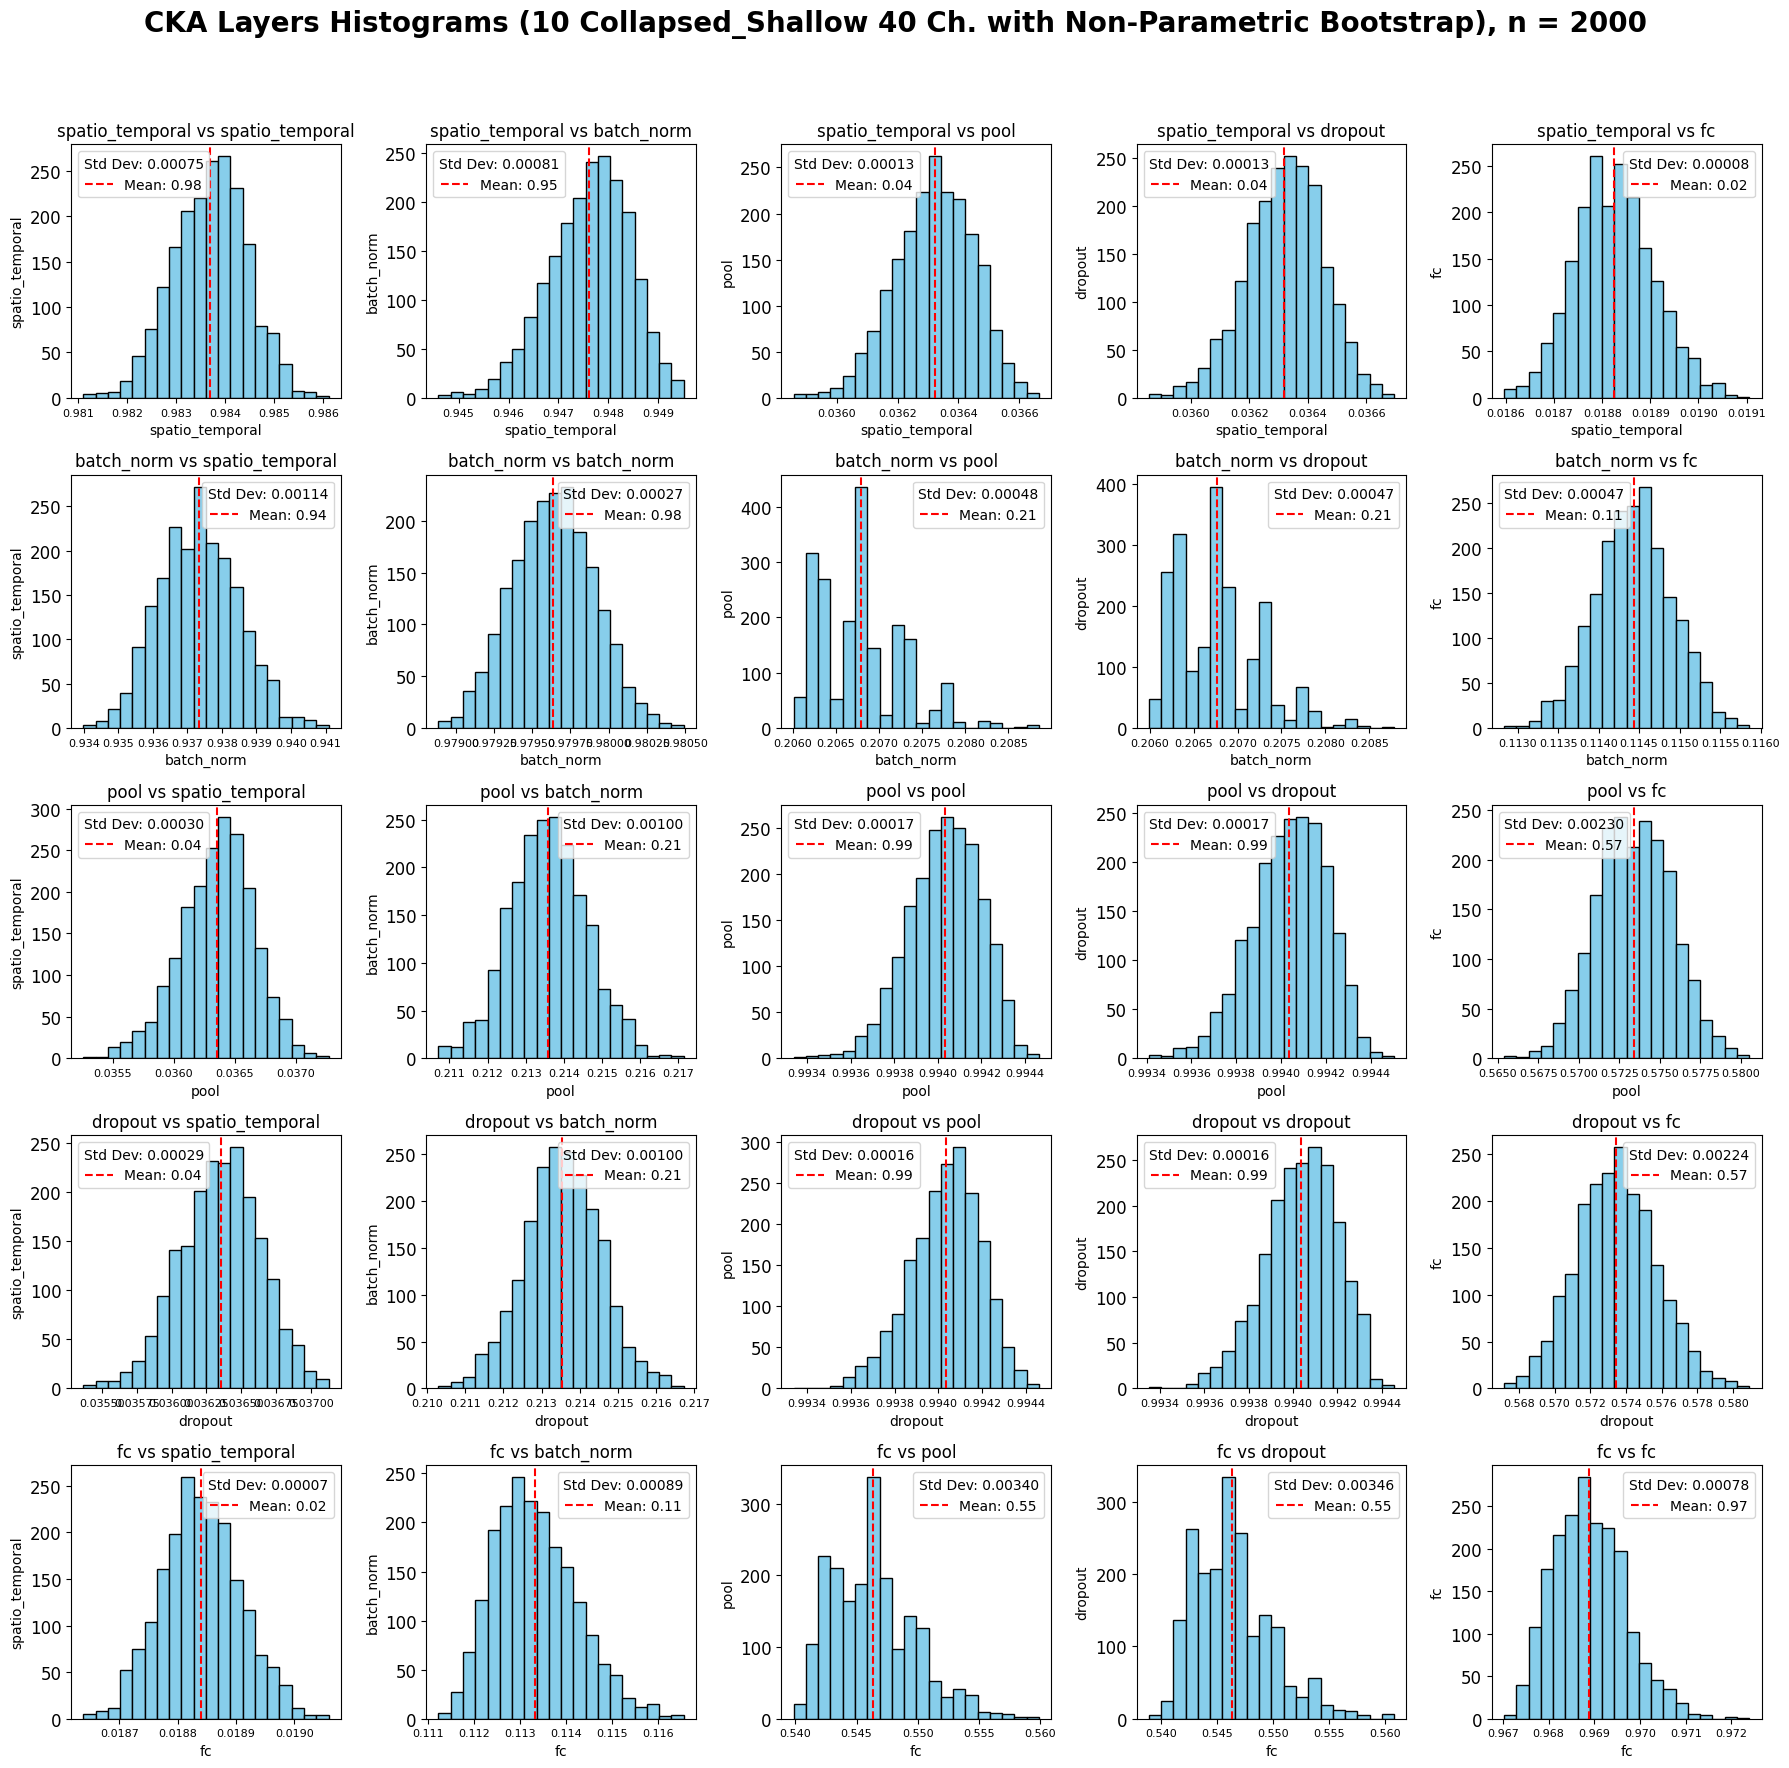

In [30]:
collapsed_shallow_mean_v_dict, collapsed_shallow_std_v_dict = plot_cka_histograms_with_bootstrap(collapsed_shallow_counter_dict, 'CKA Layers Histograms (10 Collapsed_Shallow 40 Ch. with Non-Parametric Bootstrap), n = 2000')


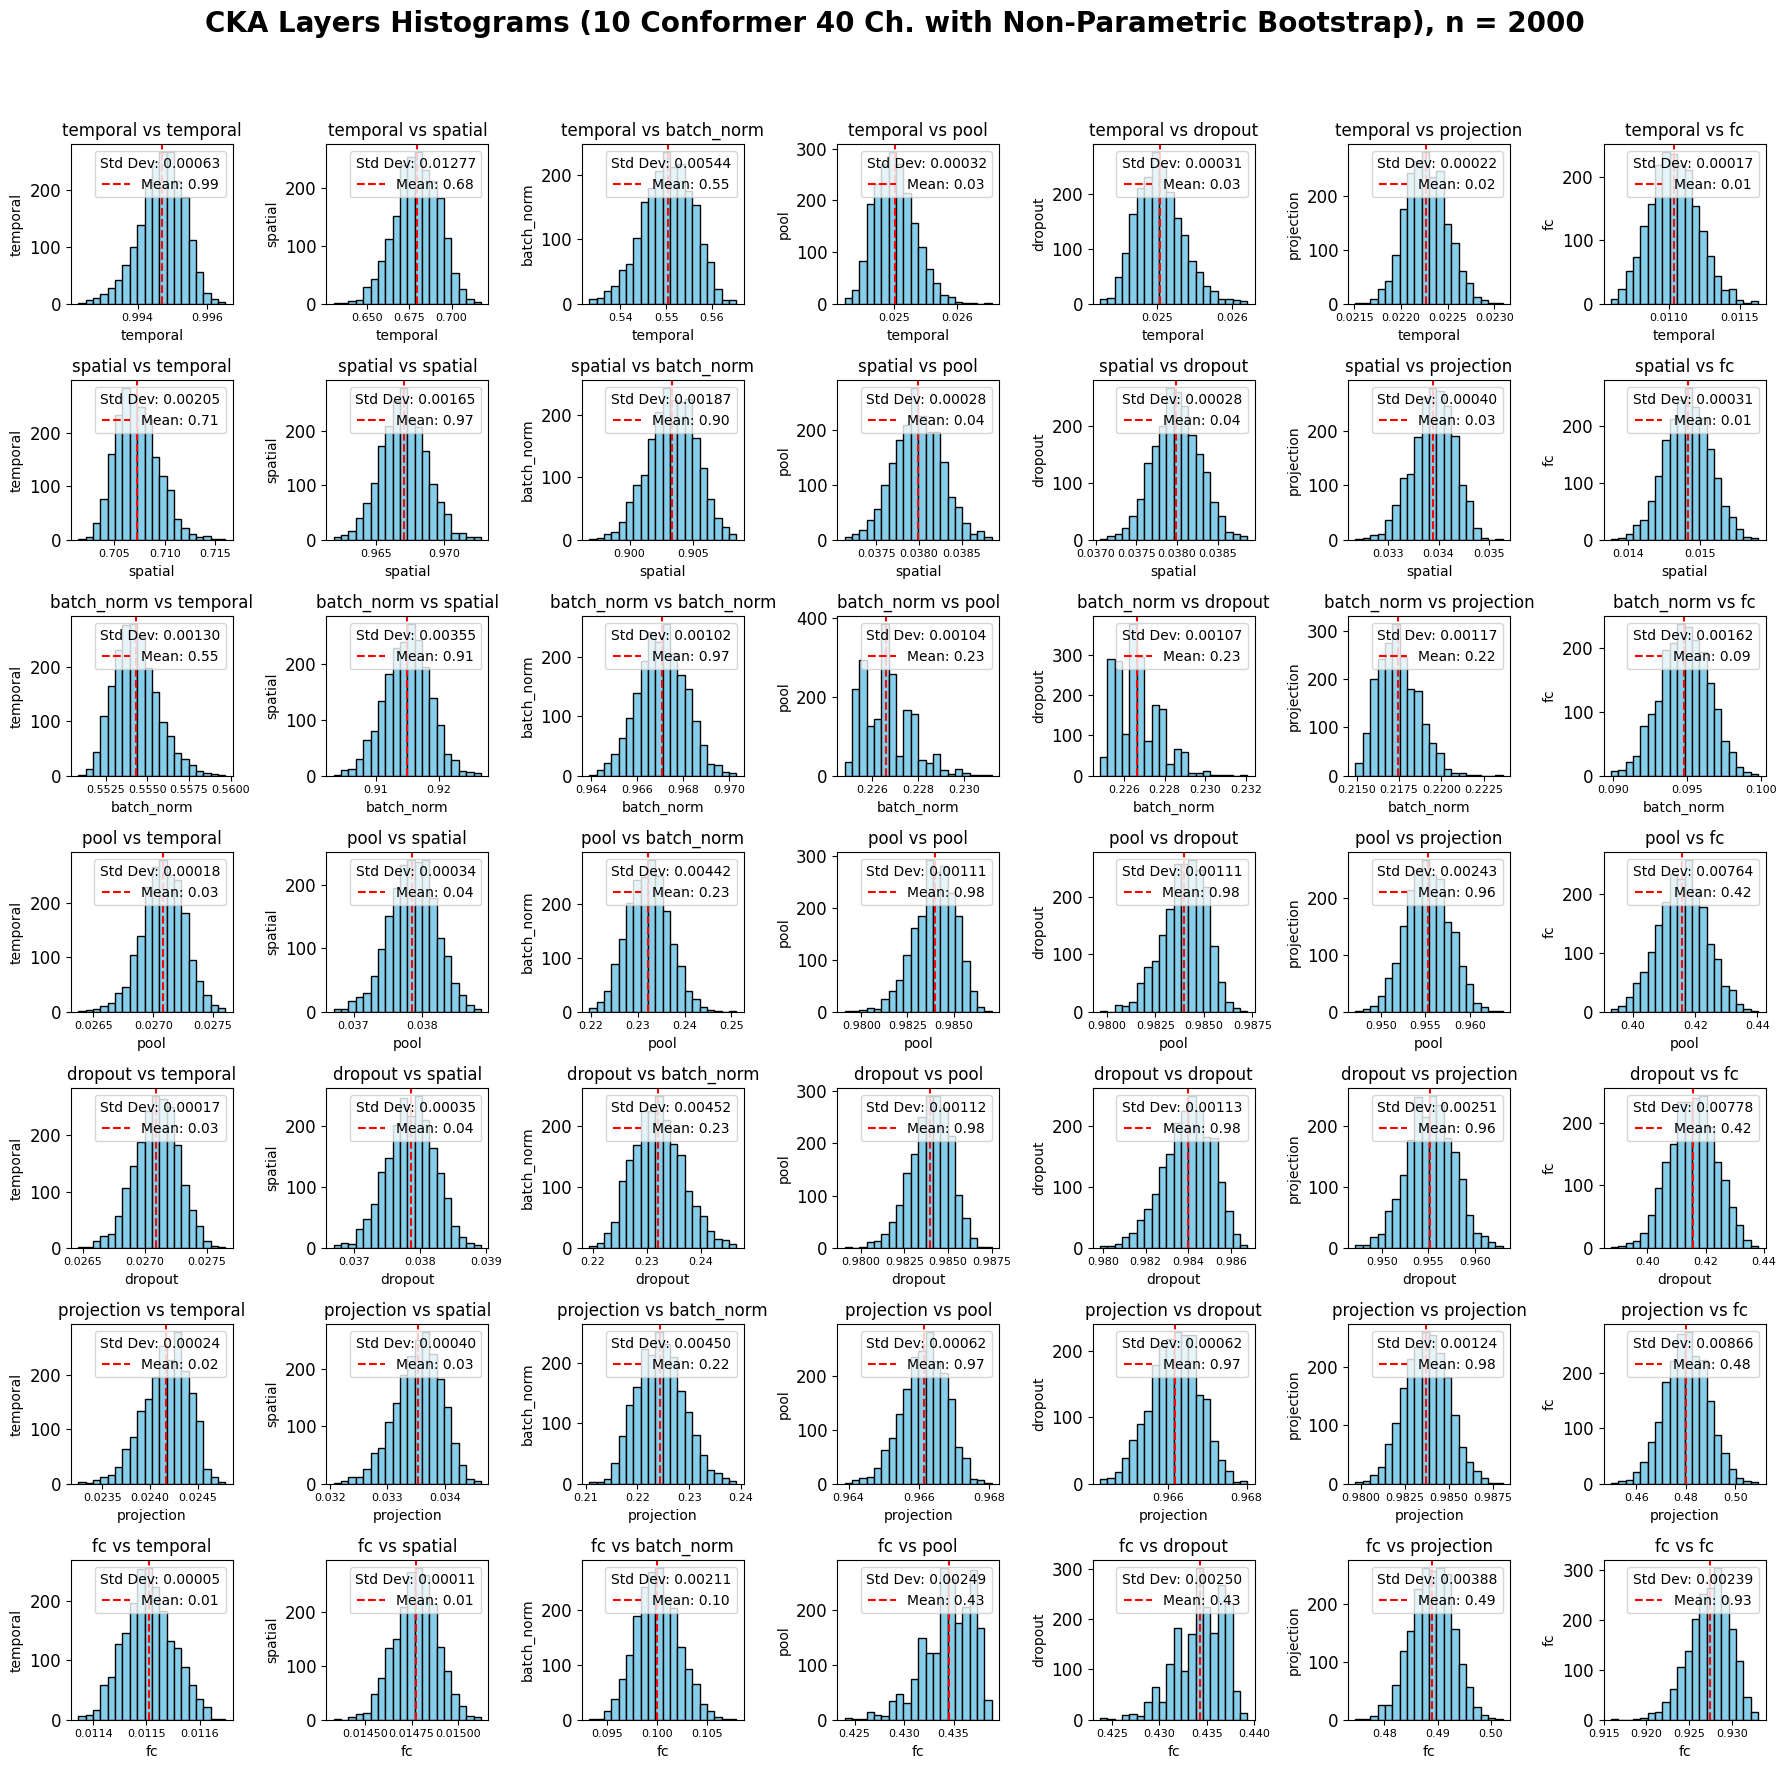

In [31]:
conformer_mean_v_dict, conformer_std_v_dict  =plot_cka_histograms_with_bootstrap(conformer_counter_dict, 'CKA Layers Histograms (10 Conformer 40 Ch. with Non-Parametric Bootstrap), n = 2000')


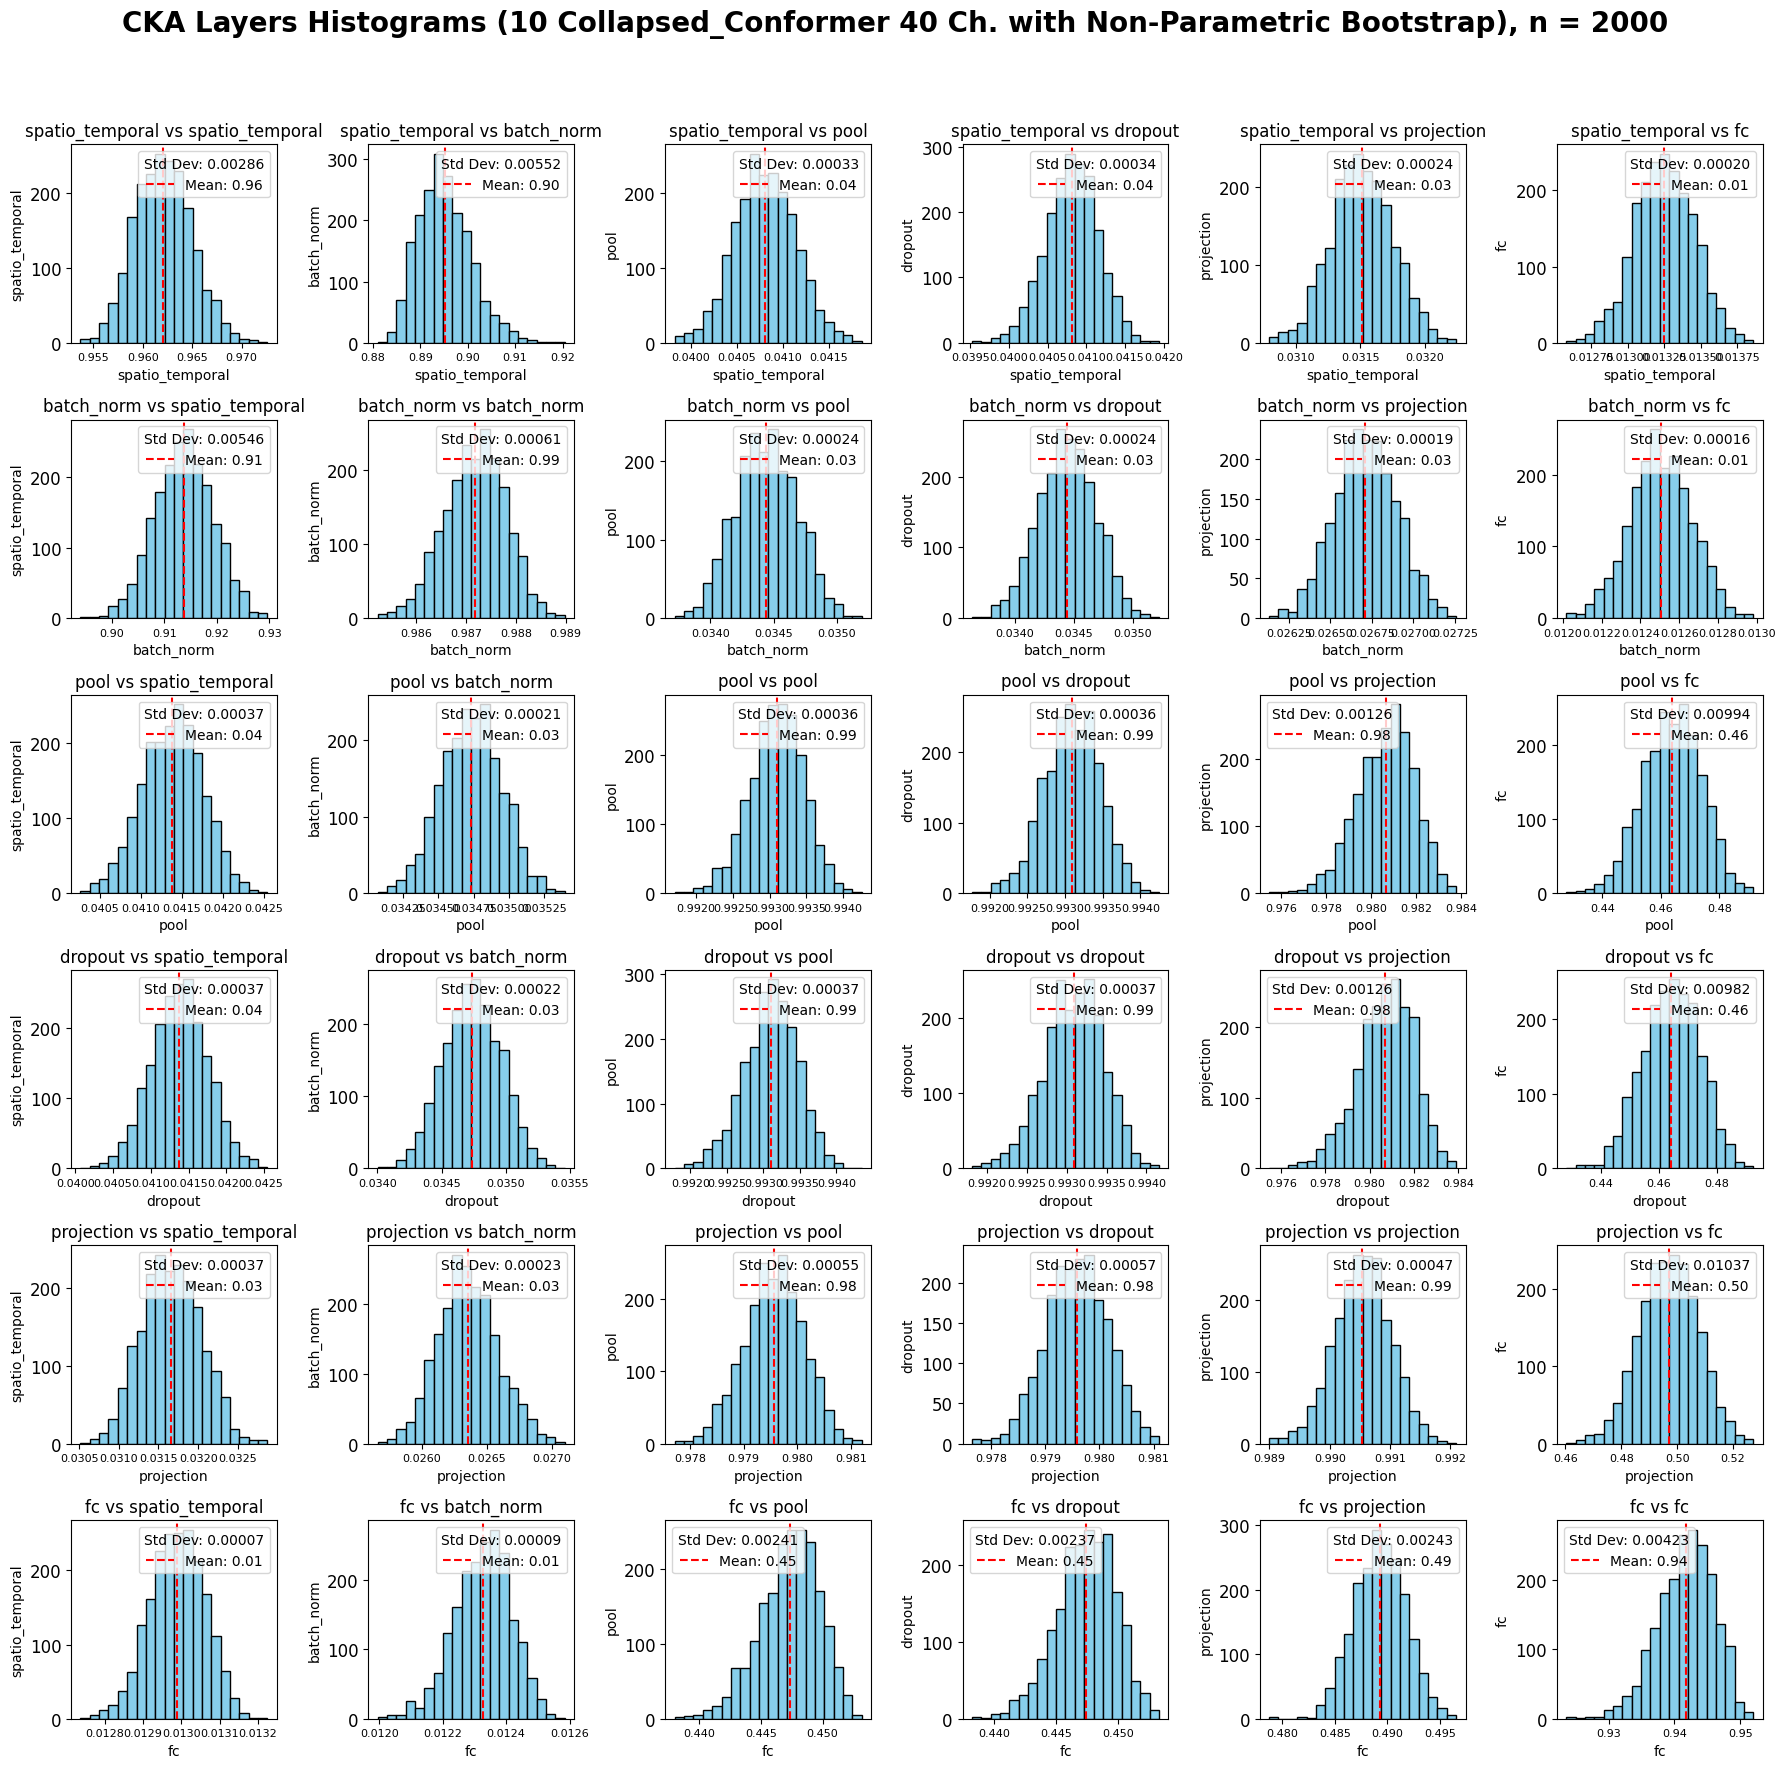

In [32]:
collapsed_conformer_mean_v_dict, collapsed_conformer_std_v_dict = plot_cka_histograms_with_bootstrap(Collapsed_conformer_counter_dict, 'CKA Layers Histograms (10 Collapsed_Conformer 40 Ch. with Non-Parametric Bootstrap), n = 2000')


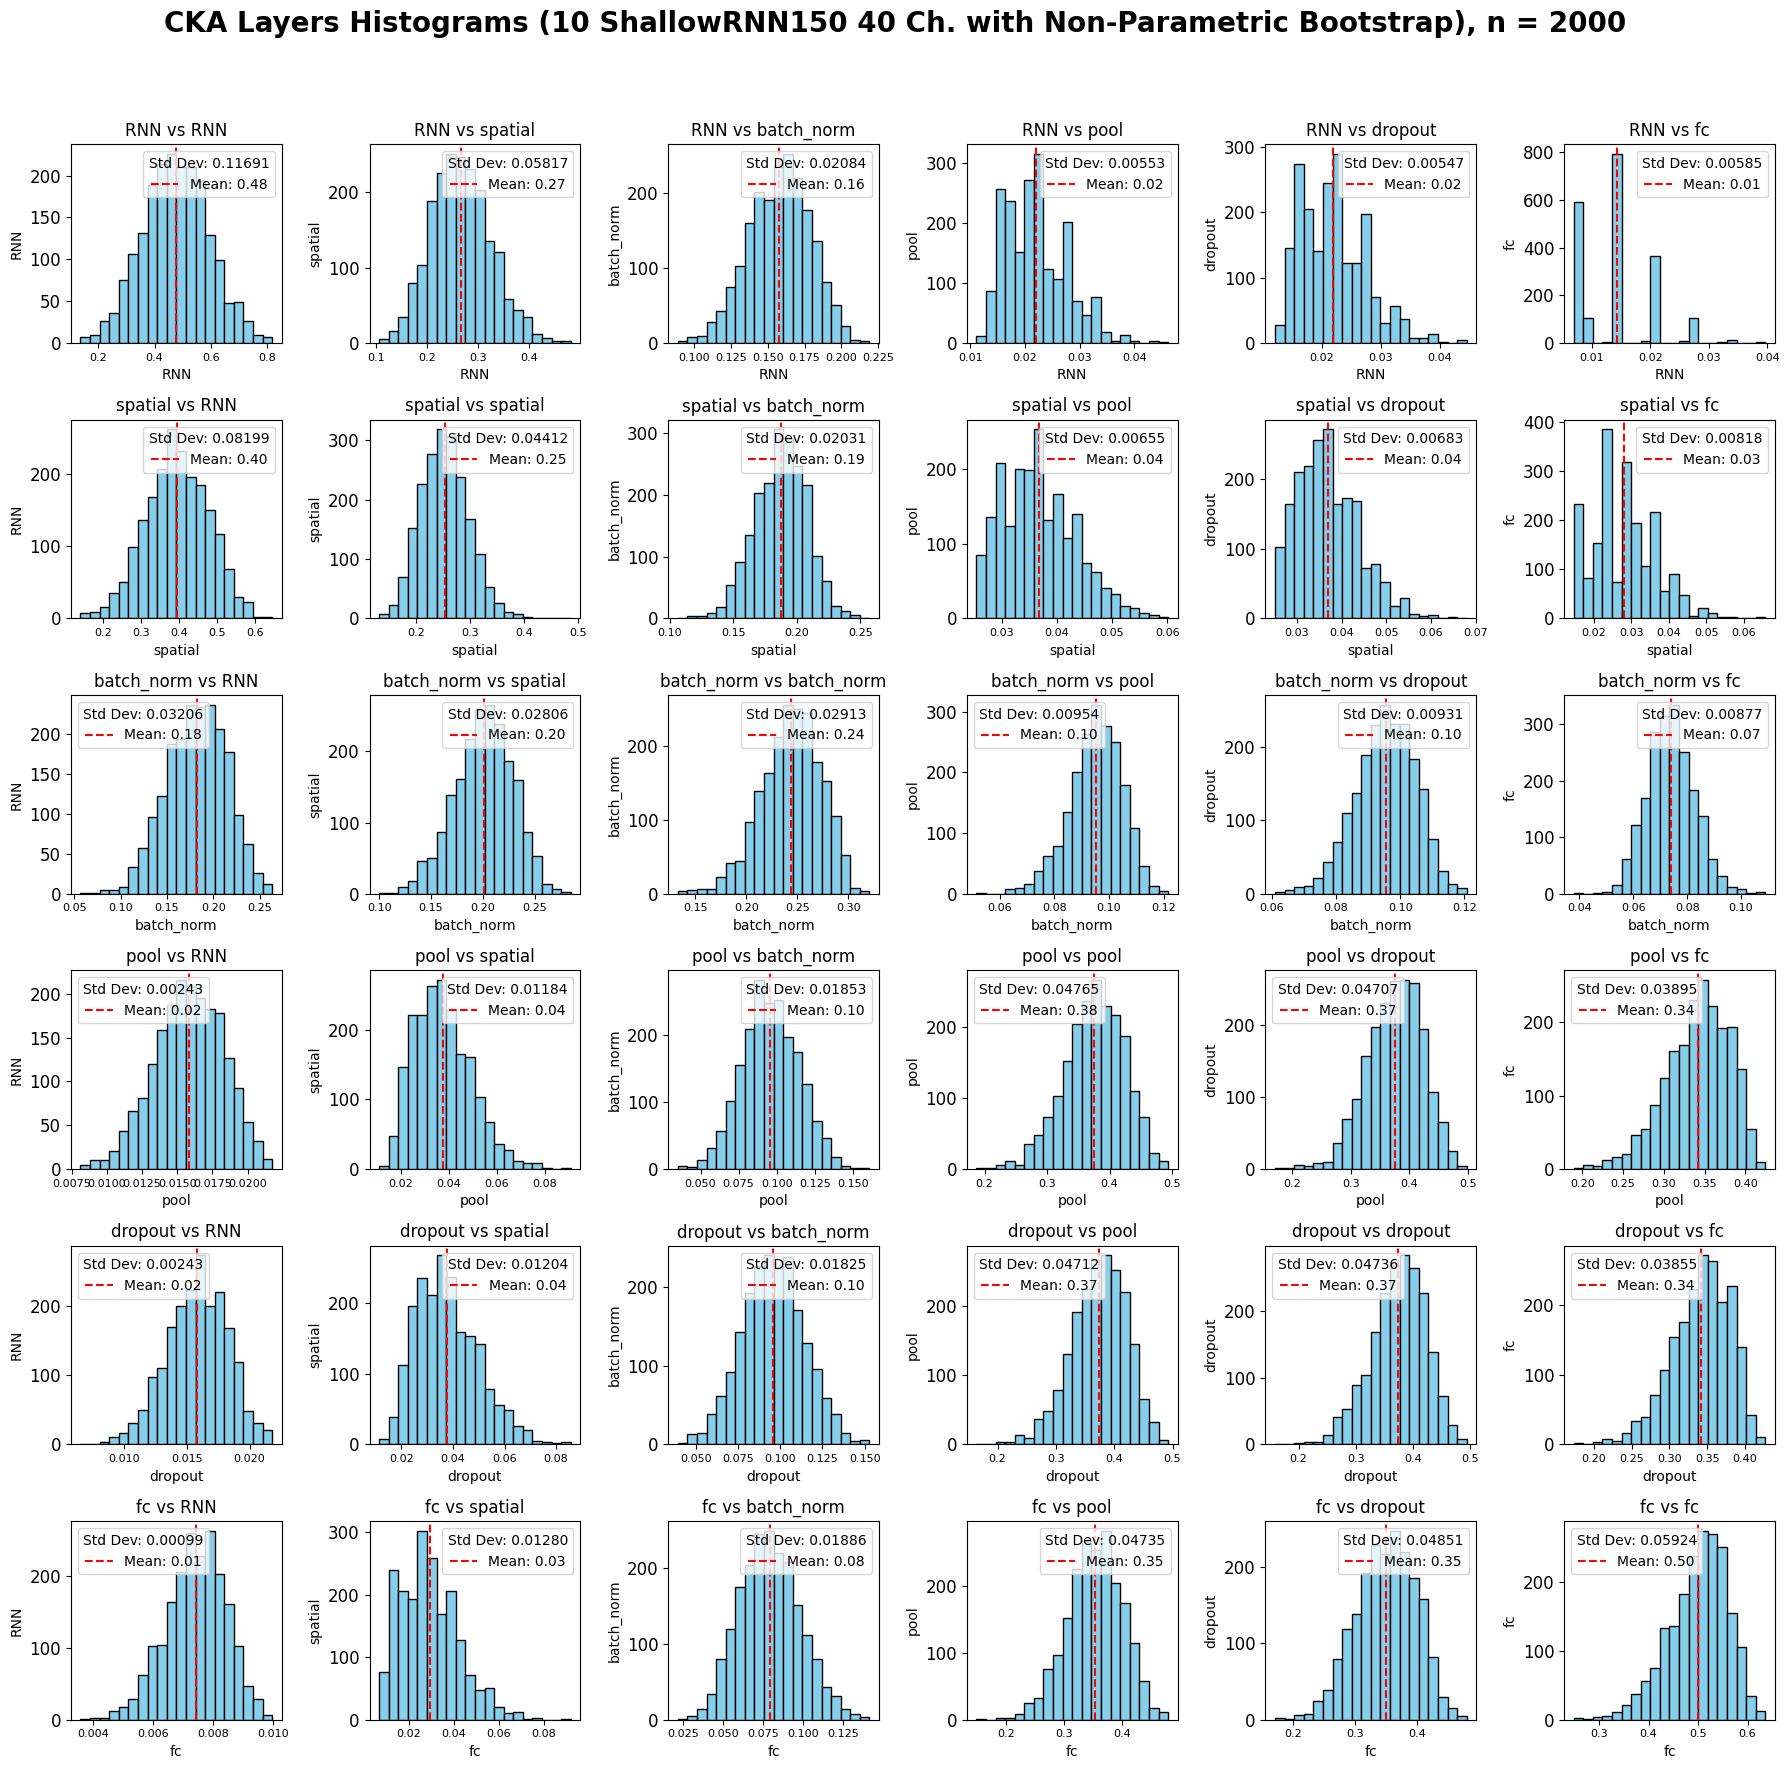

In [33]:
shallowRNN150_mean_v_dict, shallowRNN150_std_v_dict = plot_cka_histograms_with_bootstrap(shallowRNN150_counter_dict, 'CKA Layers Histograms (10 ShallowRNN150 40 Ch. with Non-Parametric Bootstrap), n = 2000')


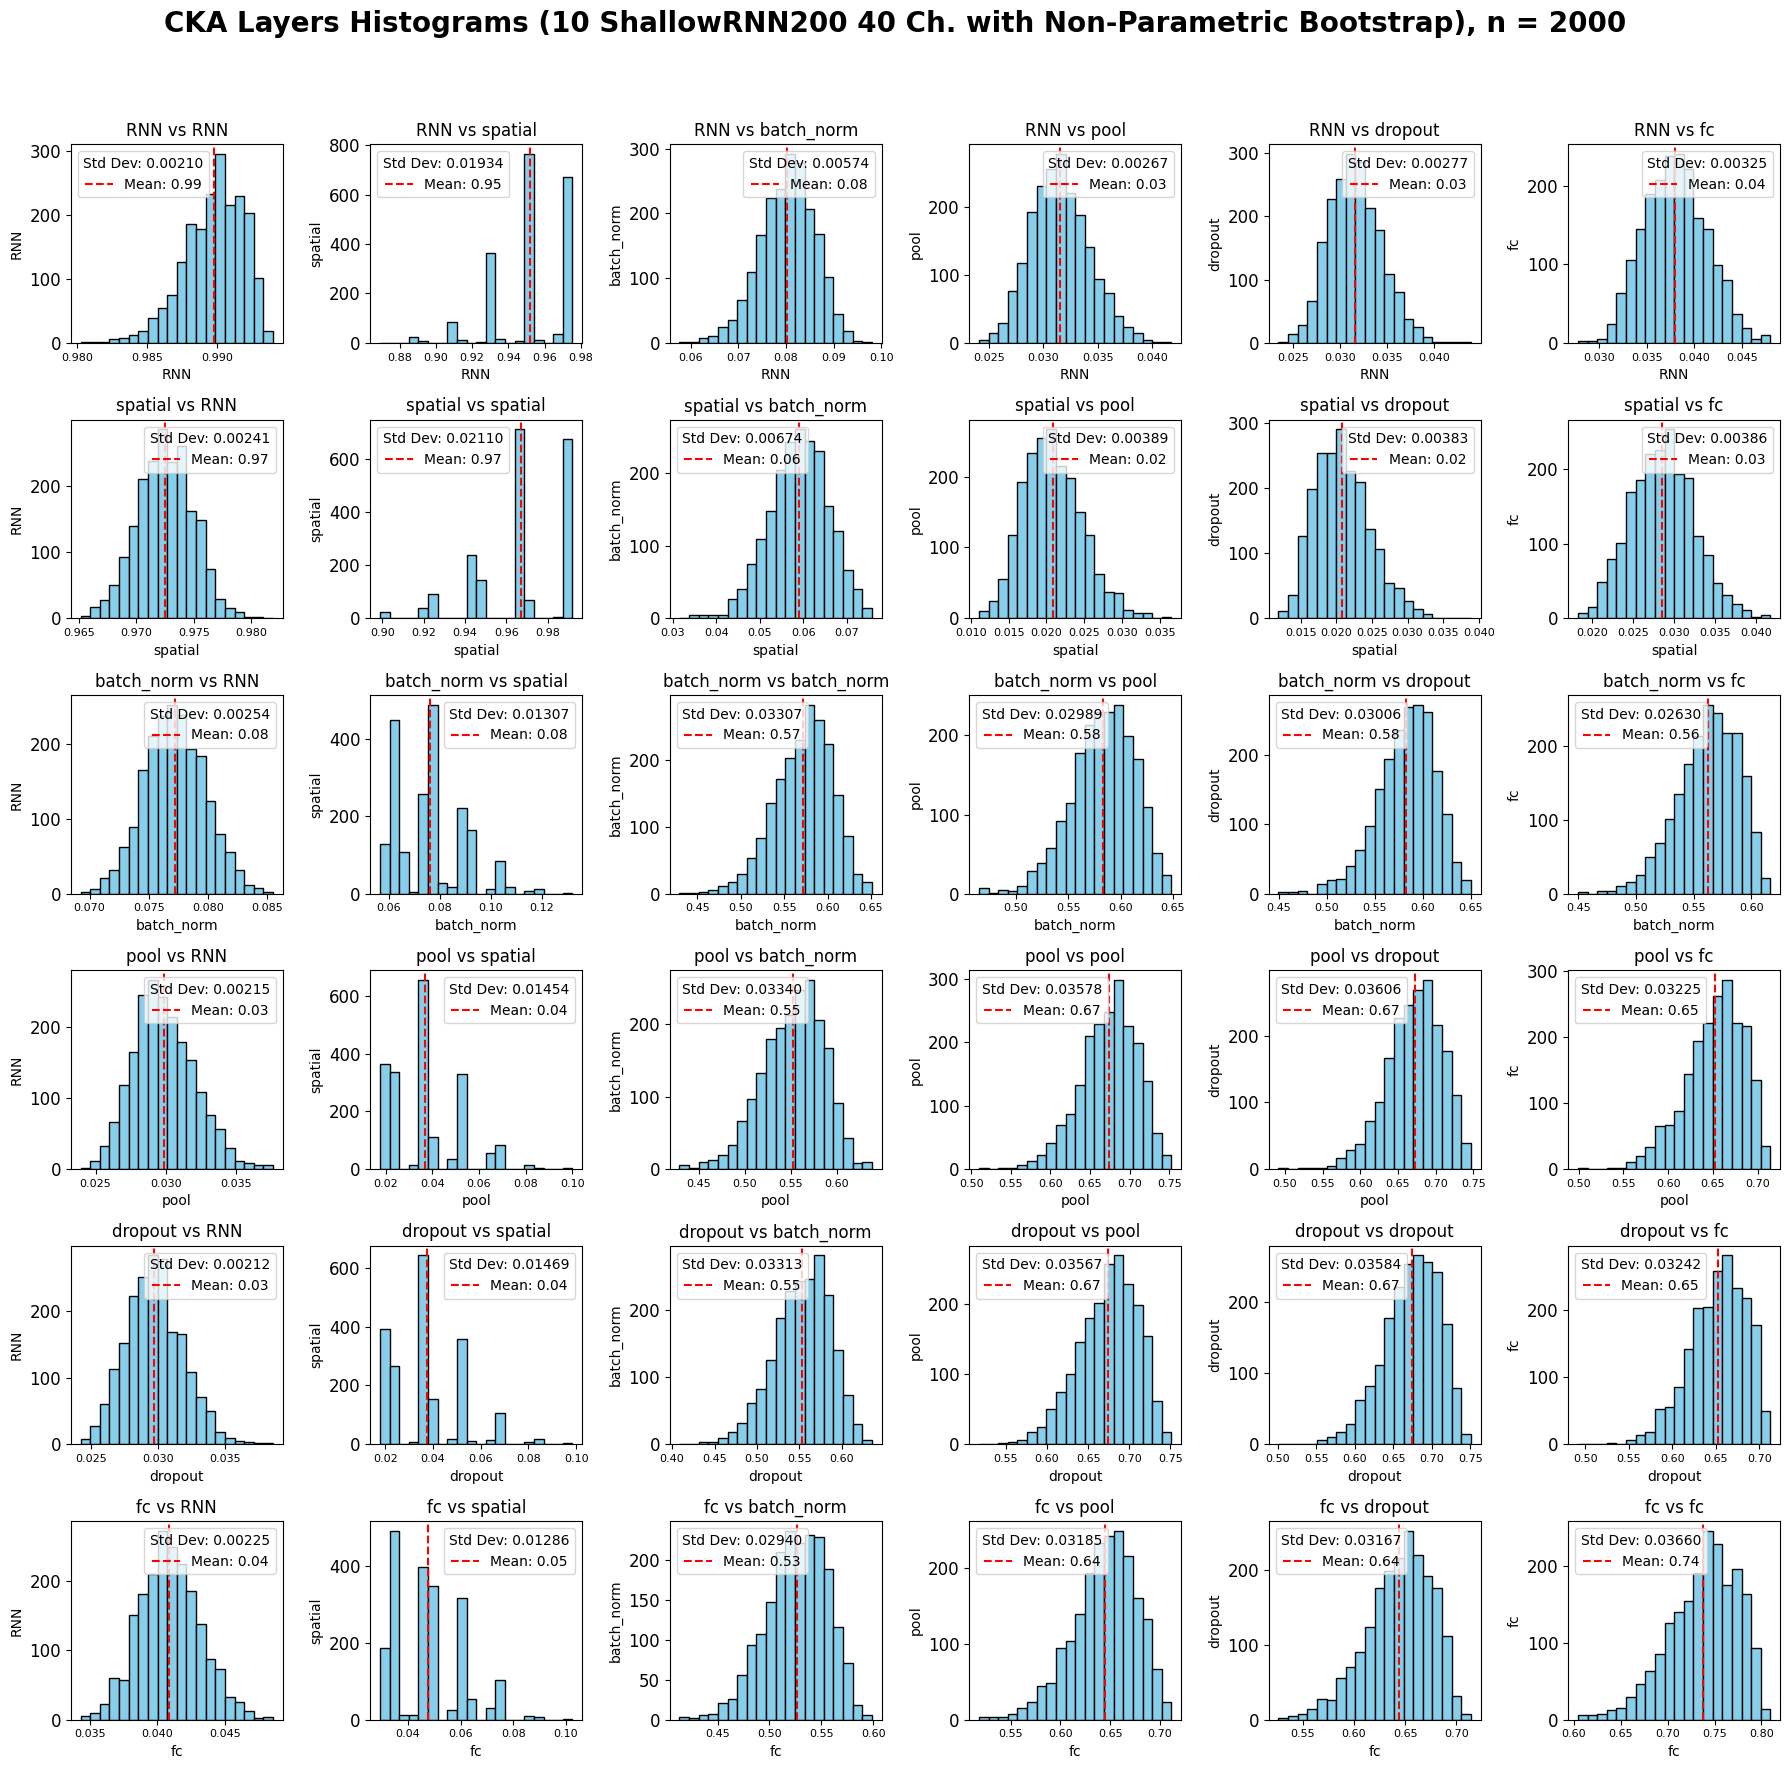

In [34]:
shallowRNN200_mean_v_dict, shallowRNN200_std_v_dict = plot_cka_histograms_with_bootstrap(shallowRNN200_counter_dict, 'CKA Layers Histograms (10 ShallowRNN200 40 Ch. with Non-Parametric Bootstrap), n = 2000')


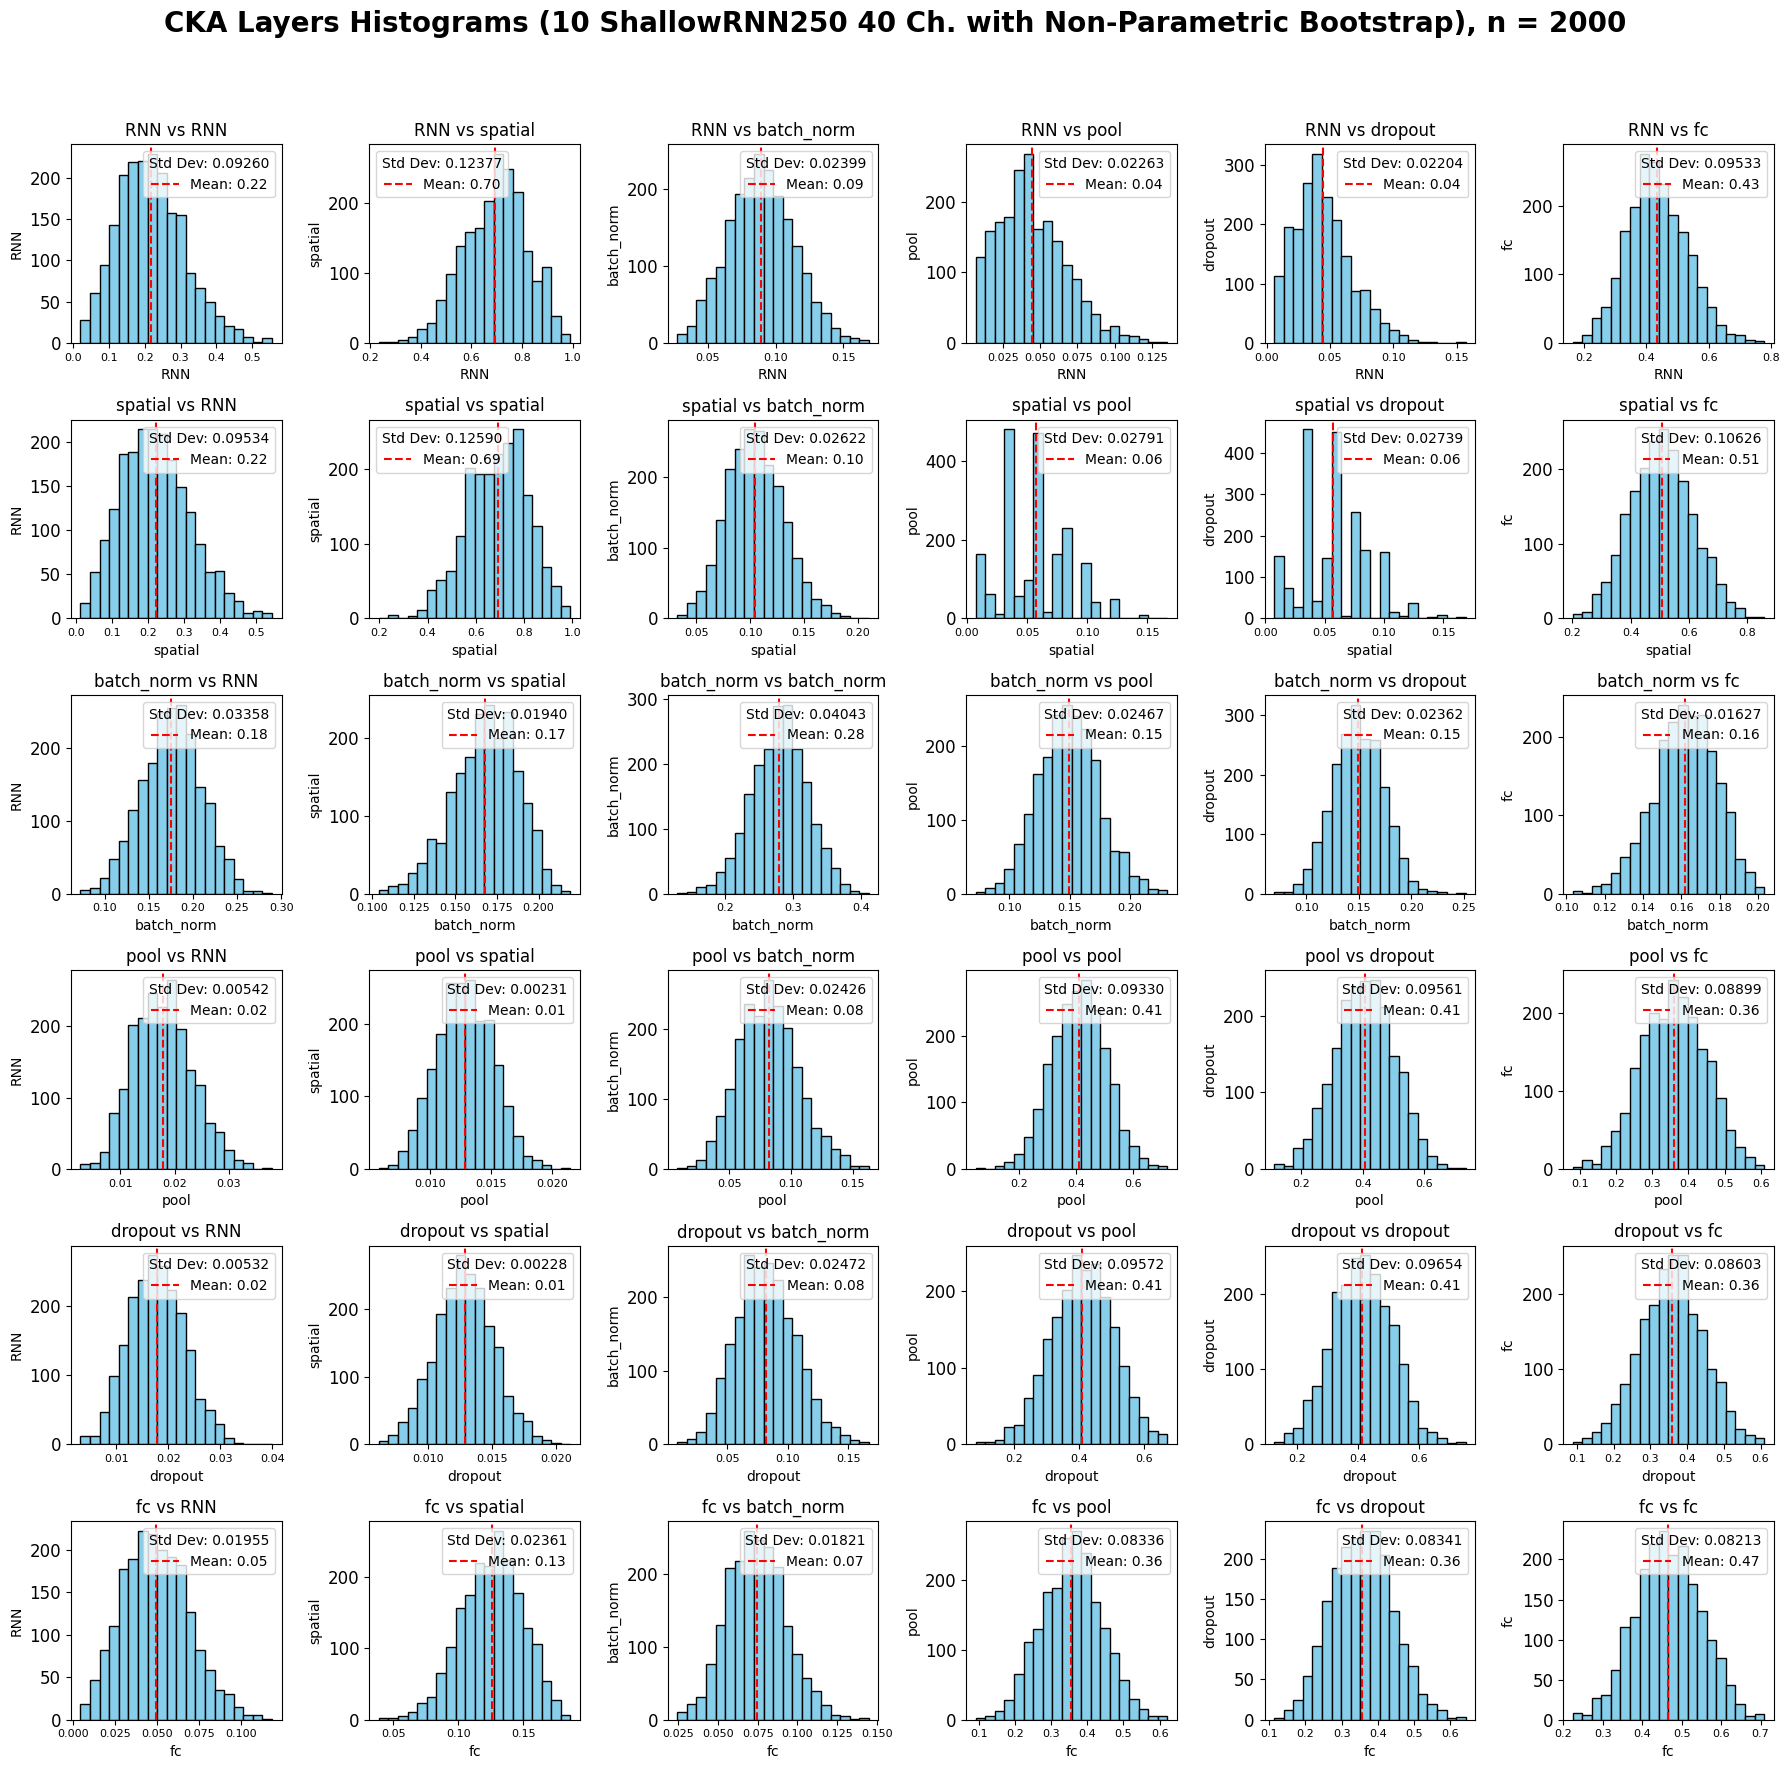

In [35]:
shallowRNN250_mean_v_dict, shallowRNN250_std_v_dict = plot_cka_histograms_with_bootstrap(shallowRNN250_counter_dict, 'CKA Layers Histograms (10 ShallowRNN250 40 Ch. with Non-Parametric Bootstrap), n = 2000')


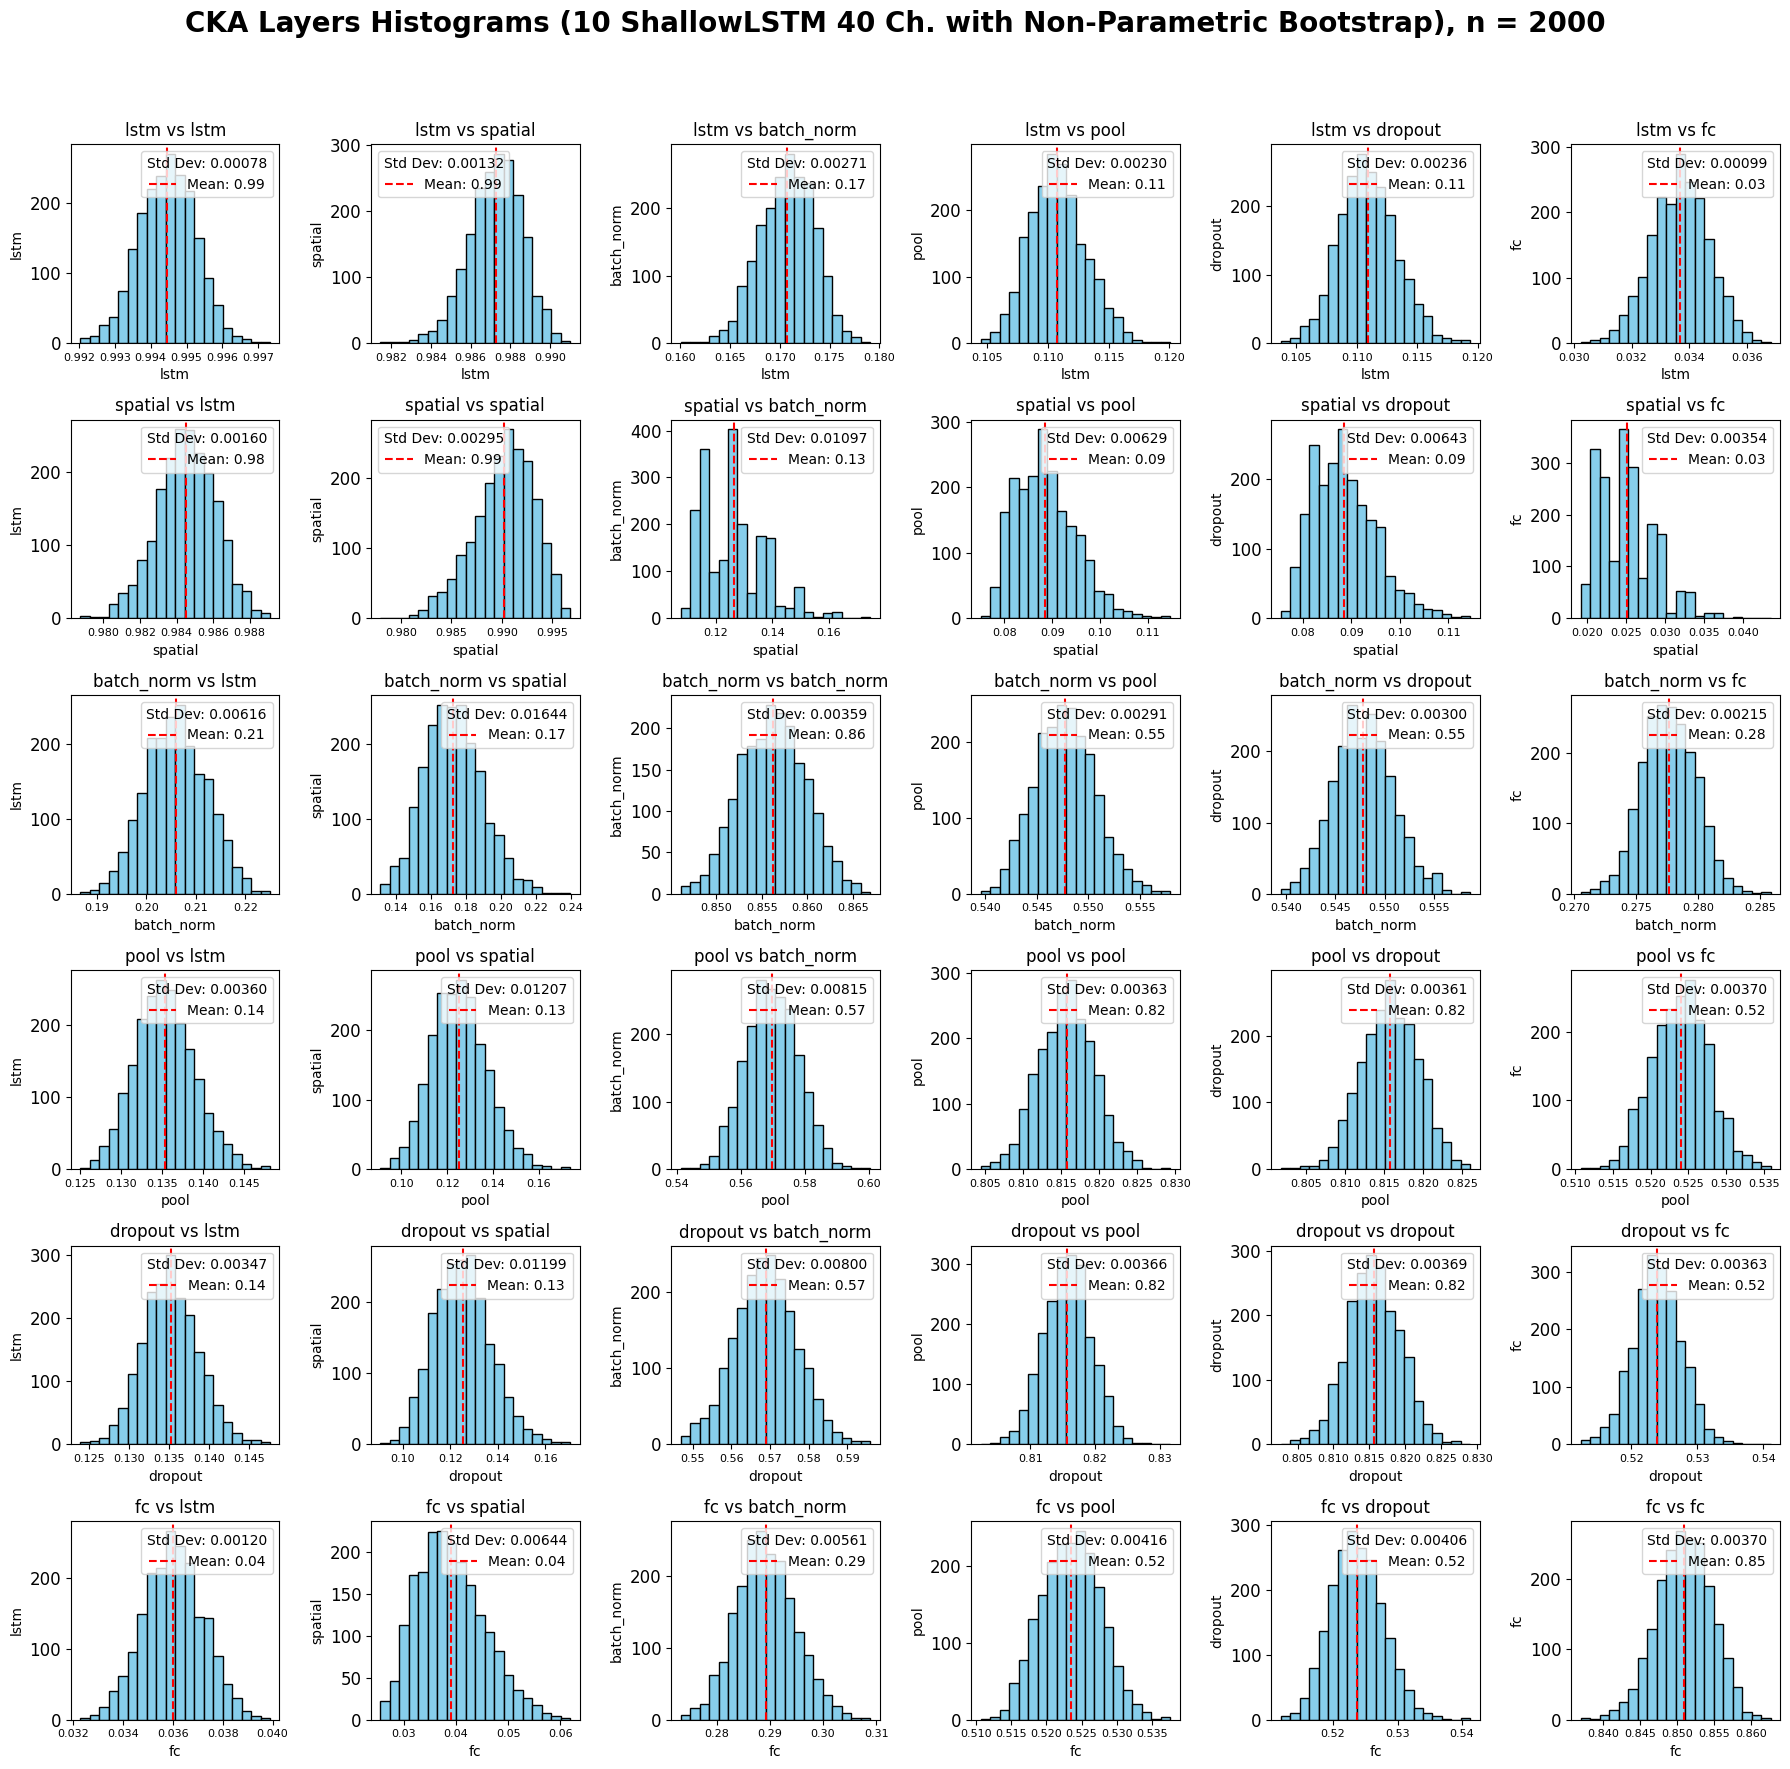

In [36]:
shallowLSTM_mean_v_dict, shallowLSTM_std_v_dict = plot_cka_histograms_with_bootstrap(shallowLSTM_counter_dict, 'CKA Layers Histograms (10 ShallowLSTM 40 Ch. with Non-Parametric Bootstrap), n = 2000')


In [37]:
#shallow_mean_v_dict, shallow_std_v_dict
#collapsed_shallow_mean_v_dict, collapsed_shallow_std_v_dict 
#conformer_mean_v_dict, conformer_std_v_dict 
#collapsed_conformer_mean_v_dict, collapsed_conformer_std_v_dict


combined_dict = {}

for (layer1, layer2) in shallow_mean_v_dict.keys():
    if layer1 == layer2:
        mean = shallow_mean_v_dict[(layer1, layer2)]
        std = shallow_std_v_dict[(layer1, layer2)]
        combined_dict[layer1] = [mean, std]

# Check the output
for layer, stats in combined_dict.items():
    print(layer, stats)


temporal [0.9977101038933209, 0.0005637084621153051]
spatial [0.9779789398040157, 0.0013537857480616436]
batch_norm [0.9503976774394569, 0.0013982444753827498]
pool [0.9842028310479527, 0.0008644913411047329]
dropout [0.9842569993237198, 0.000855138243485817]
fc [0.9519059154372104, 0.002361696180424591]


In [38]:
def get_diagonal_values(the_mean_dict,the_std_dict):
    combined_dict = {}
    for (layer1, layer2) in the_mean_dict.keys():
        if layer1 == layer2:
            mean = the_mean_dict[(layer1, layer2)]
            std = the_std_dict[(layer1, layer2)]
            combined_dict[layer1] = [mean, std]
    return combined_dict

shallow_diagonal_vals = get_diagonal_values(shallow_mean_v_dict, shallow_std_v_dict)
collapsed_shallow_diagonal_vals = get_diagonal_values(collapsed_shallow_mean_v_dict, collapsed_shallow_std_v_dict )
conformer_diagonal_vals = get_diagonal_values(conformer_mean_v_dict, conformer_std_v_dict)
collapsed_conformer_diagonal_vals = get_diagonal_values(collapsed_conformer_mean_v_dict, collapsed_conformer_std_v_dict)
shallowRNN150_diagonal_vals = get_diagonal_values(shallowRNN150_mean_v_dict, shallowRNN150_std_v_dict)
shallowRNN200_diagonal_vals = get_diagonal_values(shallowRNN200_mean_v_dict, shallowRNN200_std_v_dict)
shallowRNN250_diagonal_vals = get_diagonal_values(shallowRNN250_mean_v_dict, shallowRNN250_std_v_dict)
shallowLSTM_diagonal_vals = get_diagonal_values(shallowLSTM_mean_v_dict, shallowLSTM_std_v_dict)


In [39]:
print(shallow_diagonal_vals)
print(collapsed_shallow_diagonal_vals)
print(conformer_diagonal_vals)
print(collapsed_conformer_diagonal_vals)
print(shallowRNN150_diagonal_vals)
print(shallowRNN200_diagonal_vals)
print(shallowRNN250_diagonal_vals)
print(shallowLSTM_diagonal_vals)

{'temporal': [0.9977101038933209, 0.0005637084621153051], 'spatial': [0.9779789398040157, 0.0013537857480616436], 'batch_norm': [0.9503976774394569, 0.0013982444753827498], 'pool': [0.9842028310479527, 0.0008644913411047329], 'dropout': [0.9842569993237198, 0.000855138243485817], 'fc': [0.9519059154372104, 0.002361696180424591]}
{'spatio_temporal': [0.9836941402611536, 0.0007477074428533689], 'batch_norm': [0.9796364693543599, 0.0002664076747756077], 'pool': [0.9940317004518754, 0.0001653491601152224], 'dropout': [0.9940353800910324, 0.00016385139273480766], 'fc': [0.9688944823764006, 0.000782975621135273]}
{'temporal': [0.9946888917609706, 0.0006320901818726369], 'spatial': [0.9670465078491874, 0.0016454518435791504], 'batch_norm': [0.967075468386182, 0.0010189393022527282], 'pool': [0.9839733227840932, 0.0011134495528887039], 'dropout': [0.9839651783106863, 0.0011252947818046345], 'projection': [0.9837162650805871, 0.0012404246349079948], 'fc': [0.9274318251496766, 0.0023880053621987

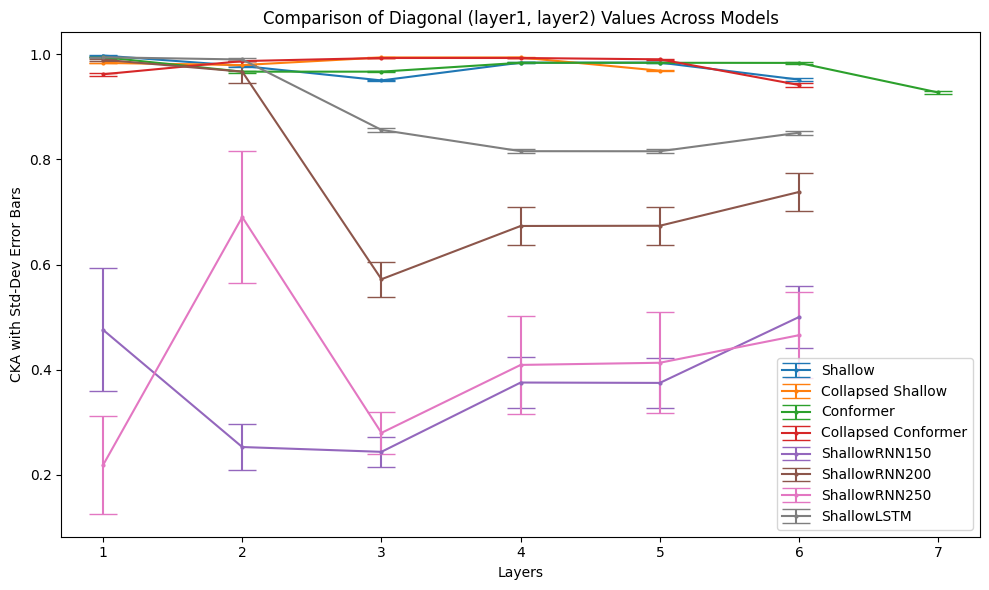

In [40]:


def plot_diagonal_values(*dicts, labels):
    plt.figure(figsize=(10, 6))

    for data, label in zip(dicts, labels):
        layers = list(range(1, len(data) + 1))  # Count the number of layers
        means = [data[layer][0] for layer in data]
        stds = [data[layer][1] for layer in data]

        # Use error bars to represent standard deviation
        plt.errorbar(layers, means, yerr=stds, fmt='o-', capsize=10, label=label, markersize= 2)

    plt.ylabel('CKA with Std-Dev Error Bars')
    plt.xlabel('Layers')
    plt.title('Comparison of Diagonal (layer1, layer2) Values Across Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_diagonal_values(shallow_diagonal_vals, collapsed_shallow_diagonal_vals, conformer_diagonal_vals, 
                     collapsed_conformer_diagonal_vals, shallowRNN150_diagonal_vals, shallowRNN200_diagonal_vals,shallowRNN250_diagonal_vals, shallowLSTM_diagonal_vals,
                     labels=['Shallow', 'Collapsed Shallow', 'Conformer', 'Collapsed Conformer', "ShallowRNN150", "ShallowRNN200", "ShallowRNN250", "ShallowLSTM"])


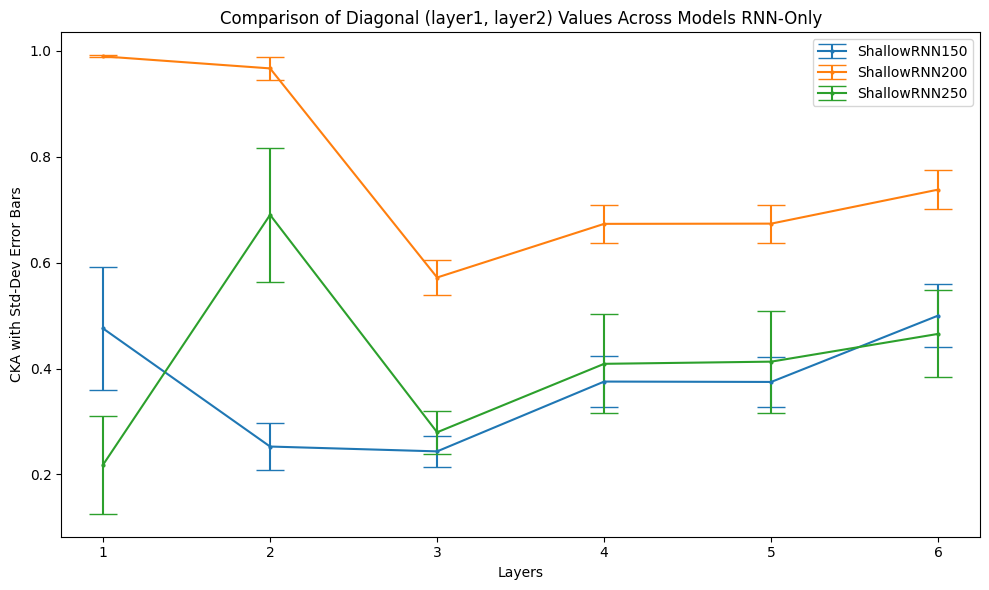

In [41]:


def plot_diagonal_values(*dicts, labels):
    plt.figure(figsize=(10, 6))

    for data, label in zip(dicts, labels):
        layers = list(range(1, len(data) + 1))  # Count the number of layers
        means = [data[layer][0] for layer in data]
        stds = [data[layer][1] for layer in data]

        # Use error bars to represent standard deviation
        plt.errorbar(layers, means, yerr=stds, fmt='o-', capsize=10, label=label, markersize= 2)

    plt.ylabel('CKA with Std-Dev Error Bars')
    plt.xlabel('Layers')
    plt.title('Comparison of Diagonal (layer1, layer2) Values Across Models RNN-Only')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_diagonal_values(shallowRNN150_diagonal_vals, shallowRNN200_diagonal_vals,shallowRNN250_diagonal_vals,
                     labels=[ "ShallowRNN150", "ShallowRNN200", "ShallowRNN250"])
